In [114]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import math
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import gamma
from itertools import permutations
import statistics
import random
pd.options.mode.chained_assignment = None

## **Dataset Summary:**

### **Covid Dataset:**
1. **Time.csv(Primary File) -** Contains cumulative data for no. of deaths and cases in entire South Korea.
2. **PatientInfo.csv** -  Contains data about the date of hospitalization, release date, deceased date, etc.
3. **TimeAge.csv** - Contains time series data of COVID-19 status in terms of the age in South Korea
4. **TimeProvince.csv** - Contains time series data of COVID-19 status in terms of the Province in South Korea

### **X Dataset:**
1. **SearchTrend.csv** - Contains search volume in the Korean Language of different respiratory diseases along with Coronavirus
2. **Weather.csv** -  Contains the data of the weather in the regions of South Korea
3. **SeoulFloating.csv** - Contains floating population data for various districts of Seoul and different age groups.

## **1. Data Cleaning**


**Outlier Removal:**

We used Tukey's rule to remove outliers and observed the below results:
* We first tried to remove outliers on the basis of "Confirmed Cases" values, but that resulted in removal of entire month of March and we had only 120 days of data with maximum cases in Feb-Mar range.
* Next, we tried to remove outliers on the basis of "Deceased Cases" values where we found 1 outlier. These deceased cases were the highest among all the cases, Hence got removed.
* Finally we removed the corresponding rows for the outlier in other tables as well to maintain consistency in data across tables.
* We did not find any missing value in our main Covid dataset. We only found some missing values in Weather and PatientInfo dataset.

**Issues Found:**

* Some columns are very sparse, like 'infected_by' column in 'patient_info' table. Hence, it was better to remove the columns as they didn't contain any significant information for our inferences. Such missing values in columns could have lead to large loss of information during data filtering if we simply dropped all the null values.
* We were getting lot of data removed due to alpha value set to 1.5 and filtering data based on cases lead to lot of major data removed. Hence, finally we set the alpha to 1.0 (suggested by prof. 1-5% ) and outlier parameter over daily deceased cases.

In [116]:
# Function to remove the outliers
def remove_outlier(df, col, index):
    
    data = df[col].values.tolist()
    data.sort()

    q1 = 0.25
    q2 = 0.5
    q3 = 0.75

    elem1 = data[math.ceil(len(data) * q1)]
    elem2 = data[math.ceil(len(data) * q2)]
    elem3 = data[math.ceil(len(data) * q3)]

    #Identifying Inter-quartile range
    iqrange = elem3 - elem1
    lrange = elem1 - 1 * iqrange
    rrange = elem3 + 1 * iqrange
    
    #Filter elements of outside range
    itr = 0
    for row in df.itertuples():
        if(row[index] < lrange or row[index] > rrange):
            print("\nRow deleted during outlier removal is ", row)
            df = df.drop(itr)
            date_value = row[1]
        itr = itr + 1
    return df, date_value

# Function to read the input data
def read_data(input_file, col_list):
    
    if(len(col_list) > 0):
        df = pd.read_csv(input_file, usecols = col_list)
    else:
        df = pd.read_csv(input_file)
    
    # Removing NULL/Missing values from dataset
    itr = 0
    for row in df.itertuples():
        for i in range(1, len(df.columns) + 1):
            if(pd.isnull(row[i]) == True):
                df = df.drop(itr)
                break
        itr = itr + 1
    return df
    

#PATH = '/content/drive/My Drive/Prob-Stats/'
#PATH = '/content/drive/My Drive/Spring-20-cl/Probs-544/coronavirusdataset/'
PATH = '/content/drive/My Drive/112609023/Data/'


# Reading the data in dataframes 
input_file = PATH+'Weather.csv'
col_list = ['province', 'date', 'avg_temp', 'min_temp', 'max_temp', \
            'precipitation', 'max_wind_speed', 'most_wind_direction', \
            'avg_relative_humidity']
weather_df = read_data(input_file, col_list)

input_file = PATH+'Time.csv'
col_list = []
time_df = read_data(input_file, col_list)

input_file = PATH+'SearchTrend.csv'
col_list = []
trend_df = read_data(input_file, col_list)

input_file = PATH+'TimeAge.csv'
col_list = []
timeage_df = read_data(input_file, col_list)

input_file = PATH+'PatientInfo.csv'
col_list = ['sex', 'birth_year', 'age', 'country', 'province', 'city', \
            'infection_case',  "released_date", "deceased_date",\
            'confirmed_date', 'state']
patientinfo_df = pd.read_csv(input_file, usecols = col_list)

input_file = PATH+'Case.csv'
col_list = []
cases_df = read_data(input_file, col_list)

input_file = PATH+'TimeProvince.csv'
col_list = []
timeprovince_df = read_data(input_file, col_list)

input_file = PATH+'SeoulFloating.csv'
col_list = []
floating_df = read_data(input_file, col_list)

print("\nData dimensions")

print("Weather:",weather_df.shape)
print("Time:",time_df.shape)
print("SearchTrend:",trend_df.shape)
print("TimeAge:",timeage_df.shape)
print("PatientInfo:",patientinfo_df.shape)
print("TimeProvince:",timeprovince_df.shape)
print("SeoulFloating",floating_df.shape)

itr = time_df.shape[0] - 1
nconf = []
ndec = []
while(itr >= 1):
    nconf.insert(0, time_df['confirmed'][itr] - time_df['confirmed'][itr - 1])
    ndec.insert(0, time_df['deceased'][itr] - time_df['deceased'][itr - 1])
    itr = itr - 1

nconf.insert(0, time_df['confirmed'][0])
ndec.insert(0, time_df['deceased'][0])

time_df['daily_confirmed'] = nconf
time_df['daily_deceased'] = ndec

#Performing outlier on daily deceased data
time_df, date_value = remove_outlier(time_df, 'daily_deceased', 9)
new_date = date_value[6:7] + '/' + date_value[8:10] + '/' + date_value[0:4]

# Remving the corresponding element in other datasets
weather_df = weather_df[weather_df.date != new_date]
trend_df = trend_df[trend_df.date != new_date]
timeage_df = timeage_df[timeage_df.date != new_date]
timeprovince_df = timeprovince_df[timeprovince_df.date != new_date]
floating_df = floating_df[floating_df.date != new_date]


Data dimensions
Weather: (25088, 9)
Time: (102, 7)
SearchTrend: (1571, 5)
TimeAge: (450, 5)
PatientInfo: (3326, 11)
TimeProvince: (1564, 6)
SeoulFloating (432000, 7)

Row deleted during outlier removal is  Pandas(Index=64, date='2020-03-24', time=0, test=348582, negative=324105, confirmed=9037, released=3507, deceased=120, daily_confirmed=76, daily_deceased=9)




---



---


## **2. Exploratory Data Analysis (EDA)** 

- ### **EDA (1): What are the number of cases over time?**

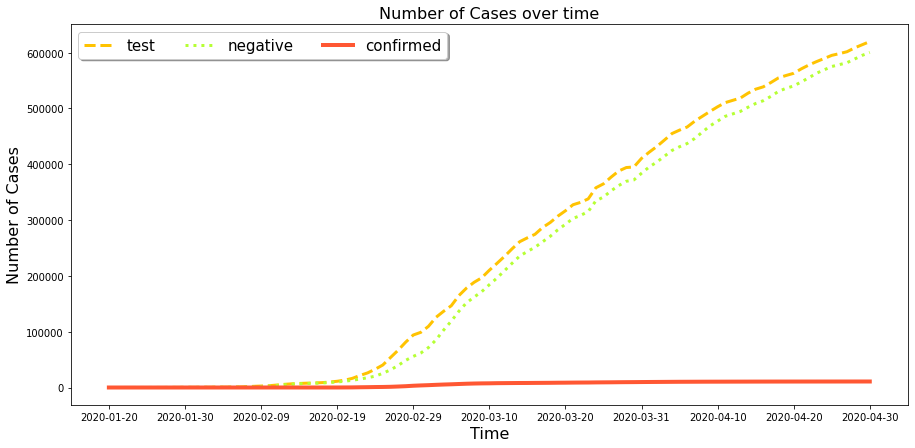

In [118]:
# plotting number of cases over time

time_pd = time_df.set_index('date')
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(time_pd['test'], label='test', linestyle='dashed', color='#FFC301', linewidth=3, markersize=6)
ax.plot(time_pd['negative'], label='negative', linestyle='dotted', color='#B6FF34', linewidth=3, markersize=6)
ax.plot(time_pd['confirmed'], label='confirmed', color='#FF5733', linewidth=4, markersize=6)
plt.title("Number of Cases over time", fontsize=16)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xlabel('Time', fontsize=16)
plt.ylabel('Number of Cases', fontsize=16)
plt.legend(loc='upper left', fancybox=True, fontsize=15, ncol=3, shadow=True)
plt.show()

**Analysis:**
1. Number of tests done were drastically increased from second last week of February (around Feb 19, 2020) until April 30th 2020 and still growing.

2. Number of postive confirmed cases once it reached the peak around Feb 29,2020, started to decrease and became constant gradually, hence flattening the curve.

* ### **EDA (2): What are the confirmed cases at different age groups and gender?**

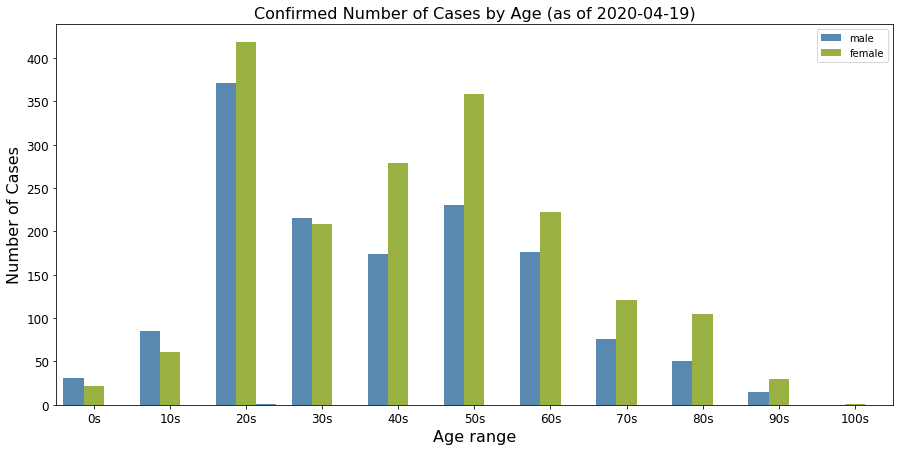

In [119]:
# Filling null values with empty spaces
patientinfo_df = patientinfo_df.fillna("")

# Finding last updated date of confirmed cases
last_update = max(patientinfo_df['confirmed_date'])
plt.figure(figsize=(15, 7))

# creating age ranges for the x-axis 
order = ['0s','10s','20s','30s','40s','50s','60s','70s','80s','90s','100s']

# plot
sns.countplot(x=patientinfo_df['age'], hue="sex", data=patientinfo_df,palette=["#4B8BBE", "#a4c330"],order =order )
plt.title('Confirmed Number of Cases by Age (as of {0})'.format(last_update), fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="upper right")
plt.xlabel("Age range", fontsize=16)
plt.ylabel("Number of Cases", fontsize=16)
plt.show()

**Analysis:**

1. The age group in the **20s** range are found to have the most number of positive cases where the number of **female** are **more than** the **male** counterpart.

2. Further risky zones in the age groups are the people in their **50s** and **40s** where again women are more prone to the virus than men.



* ### **EDA (3): What are the known reasons of infection?** 

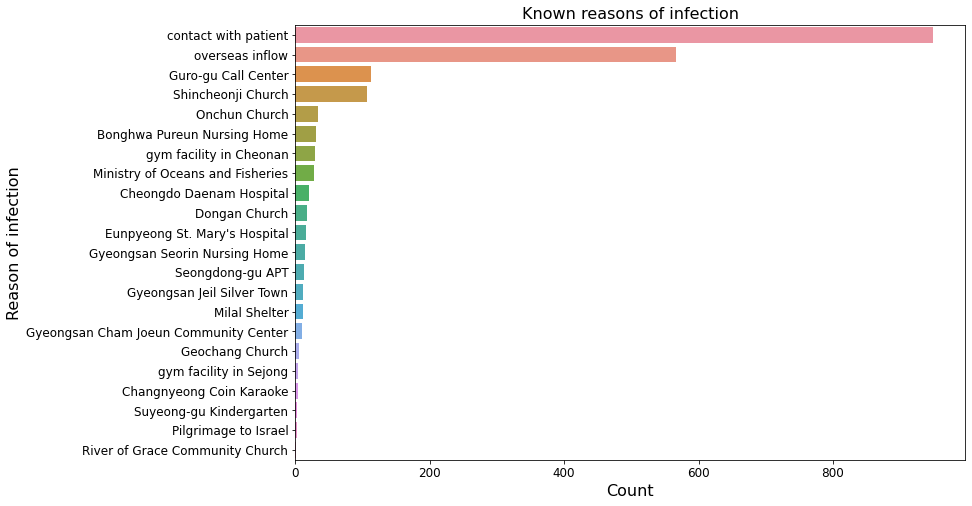

In [120]:
# plotting known reasons of infection 
pat = patientinfo_df[(patientinfo_df['infection_case']!='') & (patientinfo_df['infection_case']!='etc')]
reasons = list(pat['infection_case'].value_counts().index)
plt.figure(figsize=(12, 8))
sns.countplot(y = 'infection_case', data=pat, order=reasons)
plt.title("Known reasons of infection", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Count", fontsize=16)
plt.ylabel("Reason of infection", fontsize=16)
plt.show()

**Analysis:**

We can infer from the above plot that the top 2 prime reasons of getting coronovirus infection is either **contact with other patients** or you have an **overseas travel history**. 

* ### **EDA (4): What is the ratio between the number of people who test positive and the number of people who died?**

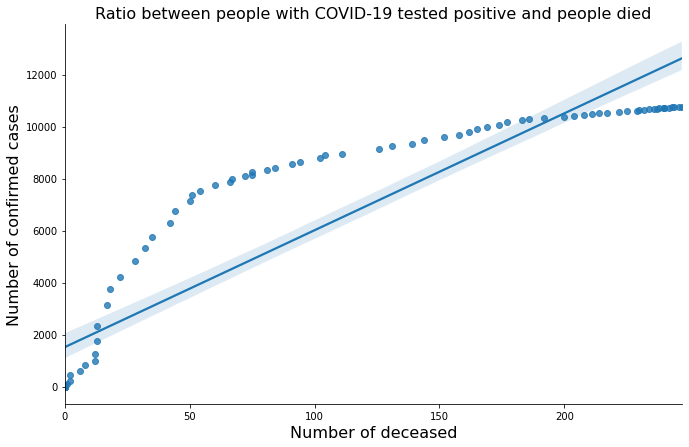

In [121]:
# plotting ratio using lmplot (linear model plot)
sns.lmplot(data=time_df,x="deceased",y="confirmed", height=6, aspect=1.6)
plt.title("Ratio between people with COVID-19 tested positive and people died", fontsize = 16)
plt.ylabel("Number of confirmed cases",fontsize=16)
plt.xlabel("Number of deceased",fontsize=16)
plt.show()

**Analysis:**
This figure displays a scatterplot of two variables, x and y, and then fit the regression model y ~ x and plot the resulting regression line and a 95% confidence interval (shaded region over the line) for that regression. Here x is the dependent variable and y is the independent variable. 

From the above graph we can infer that there are a lot of people with statistically positive test results and as per the linear relation we see, it can be said that most of them seem to have recovered.

* ### **EDA (5): What is the duration of infection for different age-groups?** 

In [0]:
# Calculating age groups in multiple of 10
def age_group(age):
    if age >= 0:
        if age % 10 != 0:
            up = int(math.ceil(age / 10.0)) * 10 - 1
            low = int(math.floor(age / 10.0)) * 10
            return f"{low}-{up}"
        else:
            up = int(age + 9) 
            low = int(age)  
            return f"{low}-{up}"
    return "Unknown"
d_cols = ["confirmed_date", "released_date", "deceased_date"]

for col in d_cols:
    patientinfo_df[col] = pd.to_datetime(patientinfo_df[col])

# Calculating birth year of each patient for current age 
patientinfo_df["current_age"] = 2019 - pd.to_numeric(patientinfo_df["birth_year"], errors='coerce')

# Calculating age-range using the above pre-defined function
patientinfo_df["age_range"] = patientinfo_df["current_age"].apply(age_group)

# Calculating time to release and death since they have been confirmed positive
patientinfo_df["time_to_release_since_confirmed"] = patientinfo_df["released_date"] - patientinfo_df["confirmed_date"]
patientinfo_df["time_to_death_since_confirmed"] = patientinfo_df["deceased_date"] - patientinfo_df["confirmed_date"]
patientinfo_df["duration_since_confirmed"] = patientinfo_df[["time_to_release_since_confirmed", "time_to_death_since_confirmed"]].min(axis=1)
patientinfo_df["duration_days"] = patientinfo_df["duration_since_confirmed"].dt.days

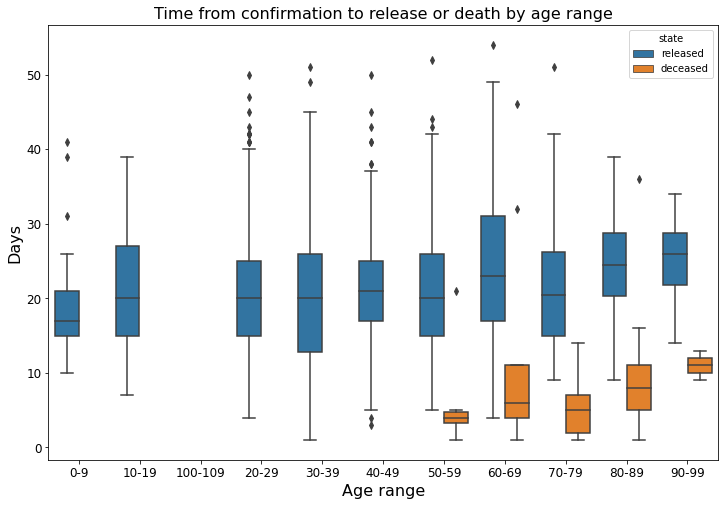

In [123]:
# filtering those patients which take atleast one day to recover or die within a minimum of one day span
epm = patientinfo_df.loc[(patientinfo_df["time_to_death_since_confirmed"].view("int64") > 0) | (patientinfo_df["time_to_release_since_confirmed"].view("int64") > 0)]

order_duration_age = sorted(patientinfo_df["age_range"].unique())[:-1]

# plot
plt.figure(figsize=(12, 8))
sns.boxplot(x="age_range",y="duration_days",order=order_duration_age,hue="state", hue_order=["released", "deceased"], data=epm)
plt.title("Time from confirmation to release or death by age range", fontsize=16)
plt.xlabel("Age range", fontsize=16)
plt.ylabel("Days", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**Analysis:**

Above represents a box-plot which gives a statistic for different age-groups against their time of recovery or death from the day they got this infection.

1. Firstly, its important to observe that higher age-groups (above the age of 50) are more prone to dying of this virus and they are unable to fight the virus for a longer time (mostly died within 10 days of getting infection). The probable reason could be low immunity rates as one ages.  

2. Secondly, most age-groups recover from this virus (assuming they are healthy with good immunity) within 18-25 days i.e around 3 weeks of good care, as most have their median lying in that range.


* ### **EDA (6): What are the daily number of new confirmed/released/deceased cases?**

In [0]:
'''for col in time_df.columns[2:7]:
    if col in [2, 4]:
        new_dict = {0: 1}
    else:
        new_dict = {0: 0}
    new_dict.update({ i : time_df[col][i] - time_df[col][i-1] for i in range(1, len(time_df)) })
    time_df['new_{}'.format(col)] = new_dict.values()
'''

# Calculating daily number of tests and confirmed cases

time_df['new_test'] = time_df.test.diff()
time_df['new_negative'] = time_df.negative.diff()
time_df['new_confirmed'] = time_df.confirmed.diff()
time_df['new_released'] = time_df.released.diff()
time_df['new_deceased'] = time_df.deceased.diff()

time_df.new_test[0] = time_df.test[0]
time_df.new_negative[0] = time_df.negative[0]
time_df.new_confirmed[0] = time_df.confirmed[0]
time_df.new_released[0] = time_df.released[0]
time_df.new_deceased[0] = time_df.deceased[0]

In [125]:
time_df[time_df["new_confirmed"]==time_df["new_confirmed"].max()]

,date,time,test,negative,confirmed,released,deceased,daily_confirmed,daily_deceased,new_test,new_negative,new_confirmed,new_released,new_deceased
40,2020-02-29,16,94055,55723,3150,28,17,813,4,12888.0,7130.0,813.0,1.0,4.0


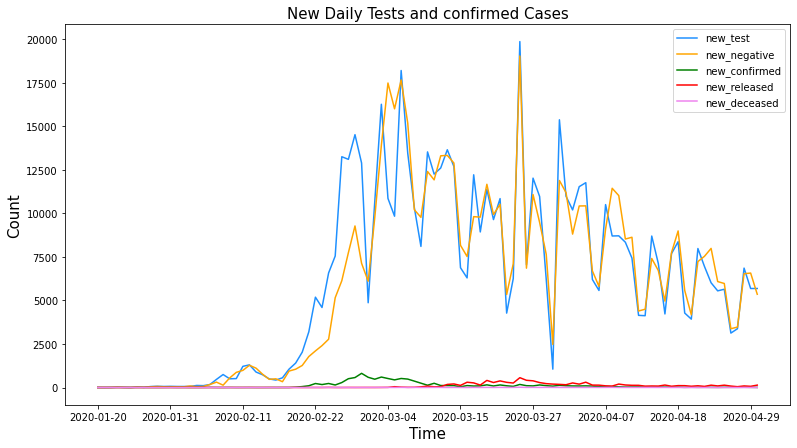

In [126]:
# plotting daily tests and confirmed cases with respect to time

fig, ax = plt.subplots(figsize=(13, 7))
plt.title('New Daily Tests and confirmed Cases', fontsize=15)
i=0
color = ['dodgerblue','orange','green','red','violet']
for test in time_df.columns[9:]:
   plt.plot(time_df.date,time_df[test], label=test, color = color[i])
   labe=time_df[test]
   i +=1
ax.set_xticks(ax.get_xticks()[::11])
ax.set_xlabel("Time", fontsize=15)
ax.set_ylabel("Count", fontsize=15)
ax.legend()
plt.show()

**Analysis:**
1. We can see that the new testing, negative and confirmed cases have started to decrease since the peak. From the figure, we can roughly estimate that the peak occured around Feb 29, 2020 as shown by the bump in the green line (having more than 800 confirmed cases which we confirmed earlier).

2. We can also see that the number of released / deceased cases kept on increasing (slight bump in the red and violet lines) up to 1 month after the peak, and then it began to decrease.

### **Using X-Datasets**

* ### **EDA (7): What is the analysis trend of different weather metrics vs. confirmed cases?**

In [0]:
# Calculating province wise confirmed cases starting with top to bottom province
cases = pd.DataFrame(cases_df.groupby(['province'])['confirmed'].sum().sort_values(ascending=False)).reset_index()

In [128]:
cases.head(18)

,province,confirmed
0,Daegu,6650
1,Gyeongsangbuk-do,1314
2,Seoul,574
3,Gyeonggi-do,556
4,Busan,139
5,Chungcheongnam-do,137
6,Gyeongsangnam-do,115
7,Incheon,79
8,Gangwon-do,51
9,Sejong,46


**Finding:**
Above shows confirmed cases in the decreasing order of different provinces. **Daegu** province has the largest number of confirmed cases of **6650** as of 4/30/2020.

In [0]:
# Calculating average values of different weather statistics under the COVID period 
weather_cov = weather_df[weather_df.date >= '2020-01-20']
weather_cov_type = weather_cov.loc[:, 'province':].groupby('province').mean()
weather_cov_avg = pd.DataFrame([weather_cov_type.index,  weather_cov_type['precipitation'], weather_cov_type['avg_temp'], weather_cov_type['avg_relative_humidity'],weather_cov_type['max_wind_speed']]).T

# ordering by confirmed cases
sorter = list(cases.province[cases.province != 'Chunghceongbuk-do'].values)
weather_cov_avg.columns = ['location', 'precipitation','temperature', 'relative_humidity','max_wind_speed']
weather_cov_avg['location'] = weather_cov_avg['location'].astype('category')
weather_cov_avg.location.cat.set_categories(sorter, inplace=True)
weather_cov_avg = weather_cov_avg.sort_values(['location'])
weather_cov_avg['location']= weather_cov_avg['location'].astype(str)

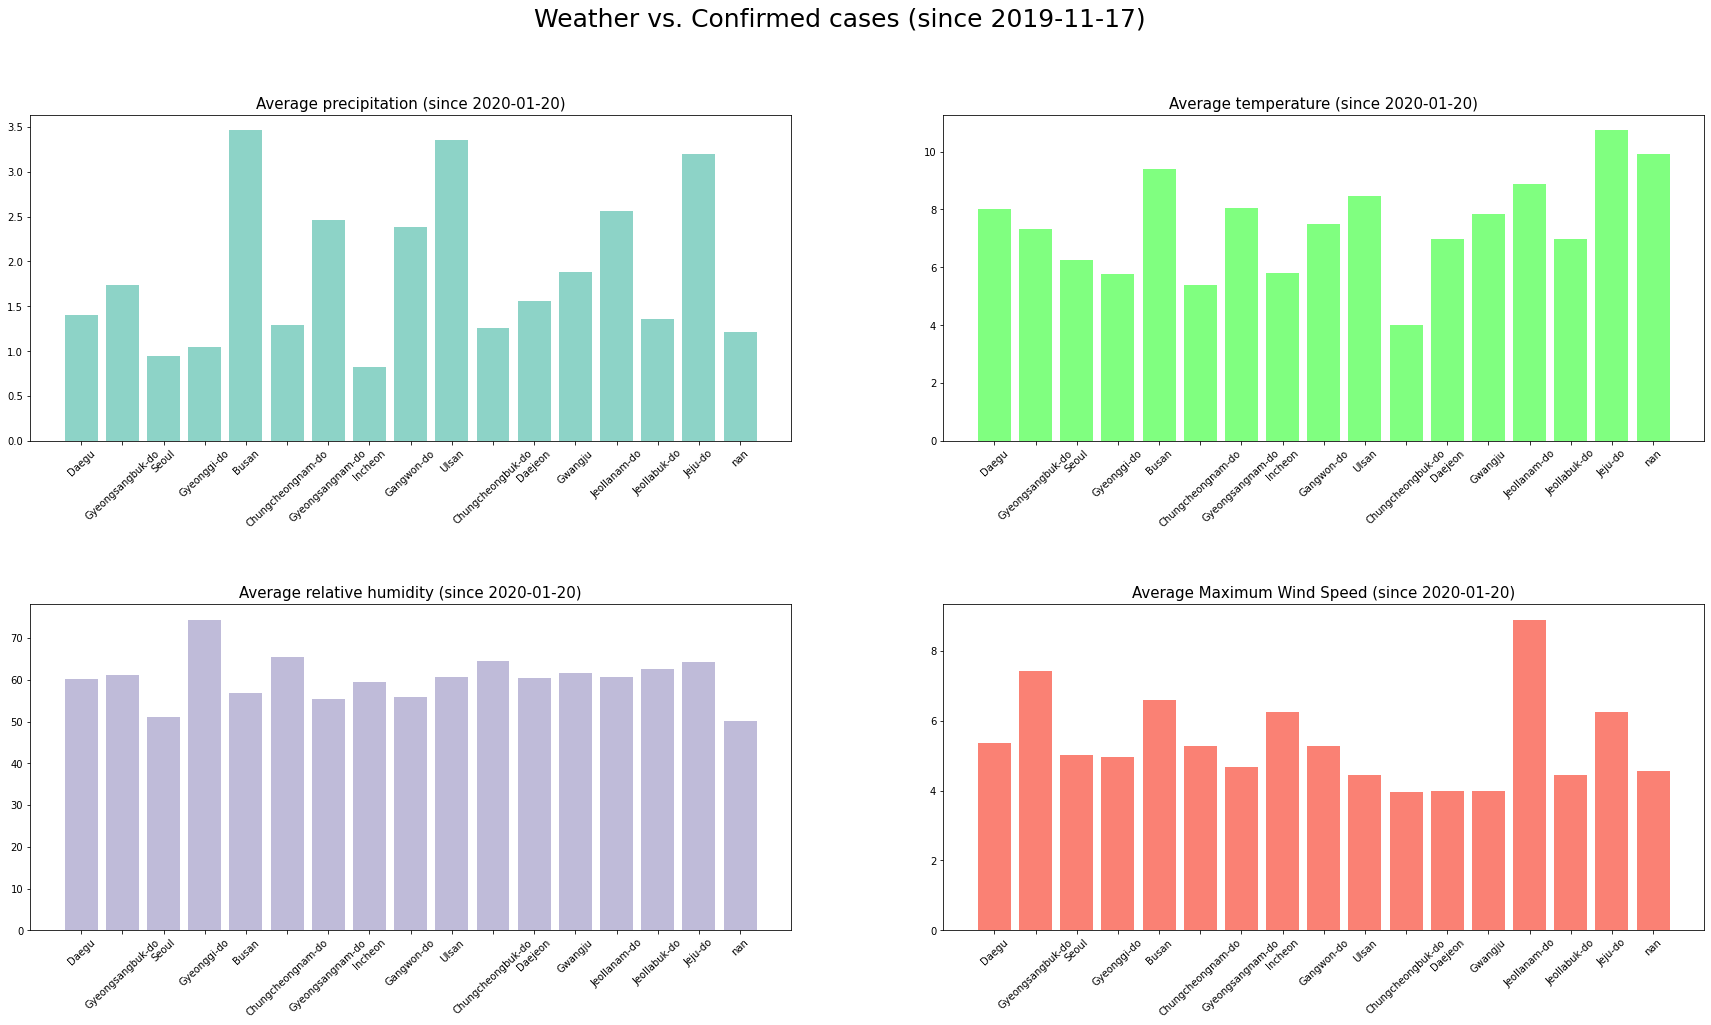

In [130]:
# plotting the avg. weather statistics for all the provinces

title_list = ['Average precipitation','Average temperature', 'Average relative humidity','Average Maximum Wind Speed']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 15))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Weather vs. Confirmed cases (since 2019-11-17)',fontsize=25)
j=0
color_list = ['#8DD3C7', '#80ff80', '#BFBBD9', '#FA8174']
for ax,col, title in zip(axes.flatten(),weather_cov_avg.columns[1:], title_list):
    ax.set_title('{0} (since 2020-01-20)'.format(title), fontsize=15)
    ax.set_xticklabels(weather_cov_avg.location,rotation=43)
    ax.bar(weather_cov_avg.location, weather_cov_avg[col], color=color_list[j])
    j+=1

**Analysis:** 
Here, we are trying to analyze weather vs. confirmed cases (since 2019-11-17) for different provinces in South Korea.

- **Precipitation & humidity** have no correlation.
- **Temperature** follows a weak negative correlation in general i.e the more colder, hence the more cases.
- **Maximum wind speed** follows a weaker positive correlation except for one  location (with second highest number of cases) as shown in the graph.

Overall, there is no significant correlation between weather and the total number of cases.


* ### **EDA(8): What are the search trends related to Coronavirus and other Respiratory Diseases?**

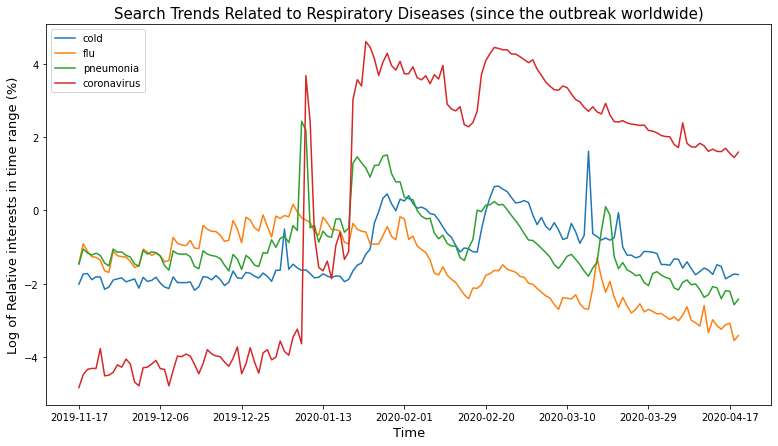

In [131]:
# Making plot of search trends for respiratory diseases since the outbreak. 
# We take the logarithmic of the trend values in order to respond to skewness towards large values

fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Search Trends Related to Respiratory Diseases (since the outbreak worldwide)', size=15)
ax.set_xlabel('Time', size=13)
ax.set_ylabel('Log of Relative interests in time range (%)', size=13)
for column in trend_df.columns[1:]:
    plt.plot(trend_df.date[trend_df.date >= '2019-11-17'], np.log((trend_df[trend_df.date >= '2019-11-17'][column])))
ax.set_xticks(ax.get_xticks()[::int(len(trend_df.date[trend_df.date >= '2019-11-17'])/8)])
ax.legend(['cold', 'flu', 'pneumonia','coronavirus'],loc='upper left')
plt.show()

**Analysis:**

The above represents the **log visualization** of relative search interests of people in the given time range.

1. The search of term "coronavirus" began around late December when it had severly hit the city of Wuhan, the epicentre of this virus.

2. Increase in the search of pneumonia was prior to that of coronavirus because it was also called Wuhan pneumonia initially in South Korea (Referrence : Google).

3. Since then, coronavirus kept dominating in the search trends. On Jan 23, 2020, three days after the 1st case in South Korea, it reached 100% significance in the search trends.

4. There has been no distinct change occured for about 2 months. The number of searches have started to decrease gradually as the situation had been taken under control.

* ### **EDA(9): What are the Search Trends Related to Different Respiratory Diseases since the 1st case in South Korea?**

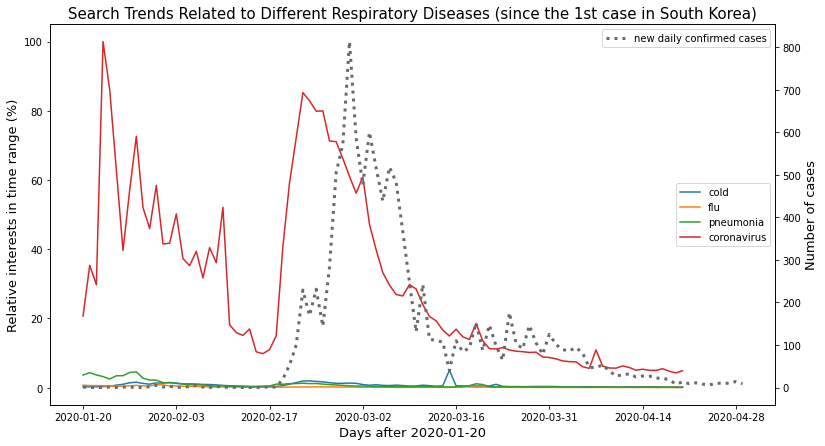

In [132]:
# Calculating plot for search Trends for Different Respiratory Diseases 

fig, ax1 = plt.subplots(figsize=(13, 7))
plt.title('Search Trends Related to Different Respiratory Diseases (since the 1st case in South Korea)', size=15)
ax1.set_xlabel('Days after 2020-01-20', size=13)
ax1.set_ylabel('Relative interests in time range (%)', size=13)
for column in trend_df.columns[1:]:ax1.plot(trend_df[trend_df.date >= '2020-01-20'].date, trend_df[trend_df.date >= '2020-01-20'][column])
ax1.set_xticks(ax1.get_xticks()[::14])
ax1.legend(['cold', 'flu', 'pneumonia','coronavirus'],loc='center right')

# Calculating plot for new Daily Confirmed Cases
ax2 = ax1.twinx()
ax2.grid(False)
ax2.set_ylabel("Number of cases", size=13)
ax2.plot(time_df.date[:-1], time_df.new_confirmed[:-1], label='new daily confirmed cases', color='dimgray',lw=3, ls=':')
ax2.set_xticks(ax2.get_xticks()[::14])
ax2.legend(loc='upper right')

plt.show()


**Analysis:**

1. After it passes the first peak, searches on Coronavirus had been decreasing for about 1 month as shown in the graph.

2. Around Feb 21, 2020 the mass confirmations in Daegu occured which probably have boosted the search on coronavirus just before then (around Feb 19, 2020). The underlying assumption could be that public already heard of having massive infections happening there.

3. After we saw the 2nd peak on Feb 22, 2020 the search volume has been shrinking again. Probably post that, the curve had started flattening and hence now its lower than that on the day of the 1st case in South Korea.



---
---
# **3. Required Inferences**

-------
## **3.1 Fatality and Cases Prediction**

**Duration:** *02-19-2020 to 03-19-2020*

* We have selected the above one month data to train our models using first 3 weeks data and then predict the last week.
* This particular time period is chosen as the maximum variation in cases was reported during this period.

**Note:** We have dropped the rows having death count per day as 0 to ease our calculation of MAPE 

In [0]:
# Selecting a period of 1 month for the analysis
month_data = time_df.copy()
month_data['date'] = month_data['date'].astype('datetime64[ns]') 
month_data['daily_cases'] = month_data.confirmed.diff()
month_data['daily_deaths'] = month_data.deceased.diff()

month_data = month_data[month_data.daily_deaths != 0]   #Dropping rows where no. of deaths is 0
month_data = month_data[month_data['date'].between('2020-02-19', '2020-03-23', inclusive=False)]


 * ### **Auto Regression (AR)**

**Formulas Used:**
$$ \hat{\beta} = (X^T.X)^{-1}X^T Y$$

$$ AR(3):  \hat{y}_{t+1|t} = \beta_0 y_t+\beta_1 y_{t-1}+\beta_2y_{t-2}+\beta_3y_{t-3} $$

$$ AR(5):  \hat{y}_{t+1|t} = \beta_0 y_t+\beta_1 y_{t-1}+\beta_2y_{t-2}+\beta_3y_{t-3}+\beta_3y_{t-4}+\beta_3y_{t-5} $$
\\
$$ MAPE: \sum_{i=1}^{n} \frac{|Y_{i}-\hat{Y}_i|} {n} \times 100 $$

$$ MSE: \frac{1}{n} \sum_{i=1}^{n} (Y_{i}-\hat{Y}_i)^2 $$


In [134]:
#Below function is used to calculate errors like MAPE and MSE 
def errors(y_test,y_pred):
    n = len(y_test)
    ape = 0
    sse = 0
    for i in range(n):
        sse += (y_test[i]-y_pred[i])**2
        ape += (abs(y_test[i]-y_pred[i])*100)/y_test[i]
        
    mse = sse/n
    mape = ape/n
    return mse,mape

#Below function is used to calculate Beta Matrix as per
def beta_cal(x,y):
    Xtrans = x.transpose()
    Xtrans_X = np.dot(Xtrans,x)
    Xtrans_X_inv = np.linalg.inv(Xtrans_X)
    Xtrans_Y = np.dot(Xtrans,y)
    Beta_vals = np.dot(Xtrans_X_inv,Xtrans_Y)
    return Beta_vals

lag = [3,5]
cases_mape = []
cases_mse = []
death_mape = []
death_mse = []

data = ['daily_cases','daily_deaths']

for p in lag:
    for col in data:
        observed = month_data[col].to_list()

        #Split data in 3 weeks train and 1 week test
        train, test = month_data[col][:21].to_numpy(), month_data[col][21:].to_numpy()
        
        y_pred = []
        for j in range(7):  #Loop runs 7 times to predict last week data
            X = []
            Y = []

            #Below portion is used to create matrix form of X and Y set
            for i in range(0,len(train),1):
                if (i+p+1)<len(train):
                    temp = np.array([1])
                    temp = np.append(temp, train[i:i+p])
                    Y.append(train[i+p])
                    X.append(temp)
            X = np.array(X)
            Y = np.reshape(Y, (-1,1))

            #Beta matrix is recalculated for every prediction value
            Beta = beta_cal(X,Y)            

            y_hat = 0
            k=1
            #Below loop is used to calculate y prediction using beta values
            for j in range(len(train)-1,len(train)-1-p,-1):
                y_hat += Beta[k]*observed[j]
                k +=1
            y_hat += Beta[0]
            train=np.append(train,y_hat)
            y_pred.append(y_hat)
        
        mse,mape = errors(test,y_pred)  #Obtaining MSE and MAPE for predictions

        if col=='daily_cases':
            cases_mape.append(mape[0])
            cases_mse.append(mse[0])
        else:
            death_mape.append(mape[0])
            death_mse.append(mse[0])

#Collecting all outputs in a dataframe    
tdata1={
'p':lag,
'MAPE(#Cases)':cases_mape,
'MSE(#Cases)':cases_mse,
'MSE(#Deaths)':death_mse,
'MAPE(#Deaths)':death_mape,
}
table1=pd.DataFrame(tdata1)
table1.index = range(1,3)
table1

,p,MAPE(#Cases),MSE(#Cases),MSE(#Deaths),MAPE(#Deaths)
1,3,115.916224,8249.418689,3.687898,22.347326
2,5,215.991328,33280.187488,3.816113,24.757293


* ### **EWMA**

**Formula Used:**
$$\hat{y}_{t+1|t}=\alpha(y_t+(1-\alpha)\hat{y}_{t-1}+(1-\alpha)^2\hat{y}_{t-2} ....)$$

In [135]:
alpha=[0.5,0.8]
cases_mape = []
cases_mse = []
death_mape = []
death_mse = []

data = ['daily_cases','daily_deaths']

for a in alpha:
    for col in data:

        #Split data in 3 weeks train and 1 week test        
        train, test = month_data[col][:21].to_list(), month_data[col][21:].to_list()
        
        y_pred = []
        for i in range(7): #Loop runs 7 times to predict last week data
            yt = 0
            power = 1

            #Below loop is used to calculate y predicted values
            for j in range(len(train)-1 ,-1,-1):
                #Multiply (1-a)^power with previous predicted y
                yt += (train[j]*((1-a)**power)) 
                power+= 1
            yt += test[i]   #Adding the true value of y for the particular day

            train.append(a*yt)
            y_pred.append(a*yt)
                    
        mse,mape = errors(test,y_pred)  #Obtaining MSE and MAPE for predictions
        
        if col=='daily_cases':
            cases_mape.append(mape)
            cases_mse.append(mse)
        else:
            death_mape.append(mape)
            death_mse.append(mse)
            
#Collecting all outputs in a dataframe 
tdata2={
'\u03B1':alpha,
'MAPE(#Cases)':cases_mape,
'MSE(#Cases)':cases_mse,
'MSE(#Deaths)':death_mse,
'MAPE(#Deaths)':death_mape,
}
table2=pd.DataFrame(tdata2)
table2.index = range(1,3)
table2

,α,MAPE(#Cases),MSE(#Cases),MSE(#Deaths),MAPE(#Deaths)
1,0.5,25.179449,474.685547,1.566907,30.442294
2,0.8,10.466499,82.108888,0.387675,16.485907


-------
## **3.2 Hypothesis Testing (Wald's, Z, T tests)**

In this task we proceed to compare the number of deaths and cases data of last and second last week.

In [136]:
time_data = time_df.copy()
cases_by_date = time_data['confirmed'].values
deaths_by_date = time_data['deceased'].values
# We convert from Cumulative to Daily data for each case in this cell.
new_cases_by_date =  np.zeros(shape=(len(cases_by_date),))
new_deaths_by_date = np.zeros(shape=(len(deaths_by_date),))
for i in range(len(cases_by_date)):
  new_cases_by_date[i] = cases_by_date[i]
  new_deaths_by_date[i] = deaths_by_date[i]
  if i == 0:
    continue
  new_cases_by_date[i] = cases_by_date[i] - cases_by_date[i-1]
  new_deaths_by_date[i] = deaths_by_date[i] - deaths_by_date[i-1]
print(new_cases_by_date)

[  1.   0.   0.   0.   1.   0.   1.   1.   0.   0.   2.   5.   1.   3.
   0.   1.   2.   5.   1.   0.   3.   0.   1.   0.   0.   0.   0.   1.
   1.   1.  20.  53. 100. 229. 169. 231. 144. 284. 505. 571. 813. 586.
 476. 600. 516. 438. 518. 483. 367. 248. 131. 242. 114. 110. 107.  40.
 110.  84.  93. 152.  87. 147.  98.  64. 176. 104.  91. 146. 105.  78.
 125. 101.  89.  86.  94.  81.  47.  47.  53.  39.  27.  30.  32.  25.
  27.  27.  22.  22.  18.   8.  13.   9.  11.   8.   6.  10.  10.  10.
  14.   9.   4.]


**One sample Wald's test**:

In this test we have that the underlying distribution is Poission. 

* By applying MLE method, we get that the estimator is Sample mean itself.
* Since variance of Poisson is lambda, we compute the standard error for Wald's accordingly.

In [0]:
def compute_walds_statistics_one_sample(lst_week, sclst_week):
  n = len(lst_week)
  # z alpha/2
  critical_value_normal = 1.96

  # 1-sample Wald's test
  mean_estimate = lst_week.sum()/n*1.0   # sample mean using last week data
  mean_true = sclst_week.sum()/n*1.0     # true mean for hypothesis

  # For poisson since variance is lambda, std_err = sqrt( sample_mean / n)(using plugin estimator)
  std_error = sqrt(mean_estimate/n*1.0)

  # computing statistic here
  walds_statistic = abs((mean_estimate - mean_true)/std_error) 

  if walds_statistic > critical_value_normal:
    print("Walds one sample Test rejects the null hypothesis of last week mean equal to second last week mean: Statistic is %0.3f" % (walds_statistic))
  else:
    print("Walds one sample Test accepts the null hypothesis of last week mean equal to second last week mean: Statistic is %0.3f" % (walds_statistic))

**Two sample Wald's test**

In [0]:
def compute_walds_statistics_two_sample(lst_week, sclst_week):
  n = len(lst_week)
  # z alpha/2
  critical_value_normal = 1.96

  # 2-sample Wald's Test
  mean_1_estimate = lst_week.sum()/n*1.0       # sample mean using last week data
  mean_2_estimate = sclst_week.sum()/n*1.0     # sample mean using second last week data

  # Computing standard error using the sample variance of the two means sqrt(var(1)/n + var(2)/n)
  sample_1_var = mean_1_estimate/n*1.0
  sample_2_var = mean_2_estimate/n*1.0
  
  std_error_2_sample = sqrt(sample_1_var + sample_2_var)

  # computing statistic here
  walds_2_statistic = abs((mean_1_estimate - mean_2_estimate - 0)/std_error_2_sample)

  if walds_2_statistic > critical_value_normal:
    print("Walds 2 population Test rejects the hypothesis that means of 2 distributions are equal: statistic is %0.3f" % (walds_2_statistic))
  else:
    print("Walds 2 population Test accepts the hypothesis that means of 2 distributions are equal: statistic is %0.3f" % (walds_2_statistic))

**One sample Z-test**

In [0]:
def compute_z_statistics(lst_week, sclst_week, total):
  n = len(lst_week)
  total_len = len(total)
  total_mn = total.mean()
  # z alpha/2
  critical_value_normal = 1.96

  # 1-sample Z test
  mean_estimate = lst_week.sum()/n*1.0   # sample mean using last week data
  mean_true = sclst_week.sum()/n*1.0     # true mean for hypothesis

  # True standard deviation of data is sample std deviation of whole data.
  stddev = 0
  for v in total:
    stddev += (v - total_mn)*(v - total_mn)/(total_len*1.0)

  denom = sqrt(stddev)/sqrt(n)

  # computing statistic here
  z_statistic = abs((mean_estimate - mean_true)/denom) 

  if z_statistic > critical_value_normal:
    print("Z Test rejects the hypothesis of last week mean equal to second last week mean: statistic is %0.3f" % (z_statistic))
  else:
    print("Z Test accepts the hypothesis of last week mean equal to second last week mean: statistic is %0.3f" % (z_statistic))

**One sample T-test**

In [0]:
def compute_t_statistics_one_sample(lst_week, sclst_week):
  #What follows are 1-sample versions of the tests
  
  n = len(lst_week)
  # t(n-1, alpha/2)
  critical_value_t = 2.447

  # 1-sample T test
  mean_estimate = lst_week.sum()/n*1.0   # sample mean using last week data
  mean_true = sclst_week.sum()/n*1.0     # true mean for hypothesis

  # Computing sample standard deviation using the sample standard deviation(s/sqrt(n))
  stddev = 0
  for v in lst_week:
    stddev += (v - mean_estimate)*(v - mean_estimate)/(n*1.0)
  stddev = sqrt(stddev)/sqrt(n)

  # computing statistic here
  t_statistic = abs((mean_estimate - mean_true)/stddev) 

  if t_statistic > critical_value_t:
    print("T Test rejects the hypothesis of last week mean equal to second last week mean: statistic is %0.3f" % (t_statistic))
  else:
    print("T Test accepts the hypothesis of last week mean equal to second last week mean: statistic is %0.3f" % (t_statistic))

**Unpaired T-test**

In [0]:
def compute_t_statistics_unpaired(lst_week, sclst_week):
  n = len(lst_week)

  # 2-sample Unpaired T Test
  mean_1_estimate = lst_week.sum()/n*1.0       # sample mean using last week data
  mean_2_estimate = sclst_week.sum()/n*1.0     # sample mean using second last week data
  critical_value_t = 2.179                     # T (7+7-2, alpha/2)

  # Computing standard error using the sample variance of the two means sqrt(var(1) + var(2))
  sample_1_var = 0
  sample_2_var = 0
  for i in range(len(lst_week)):
    sample_1_var += (lst_week[i] - mean_1_estimate)*(lst_week[i] - mean_1_estimate)/(n*1.0)
    sample_2_var += (sclst_week[i] - mean_2_estimate)*(sclst_week[i] - mean_2_estimate)/(n*1.0)
  
  std_error_2_sample = sqrt(sample_1_var + sample_2_var)

  # computing statistic here
  t_2_statistic = abs((mean_1_estimate - mean_2_estimate - 0)/std_error_2_sample)

  if t_2_statistic > critical_value_t:
    print("Unpaired T-test rejects the hypothesis that means of 2 distributions are equal: statistic is %0.3f" % (t_2_statistic))
  else:
    print("Unpaired T-test accepts the hypothesis that means of 2 distributions are equal: statistic is %0.3f" % (t_2_statistic))


**Paired T-test**

In [0]:
def compute_t_statistics_paired(lst_week, sclst_week):
  n = len(lst_week)

  diff_stat = np.array([l - sl for l, sl in zip(lst_week, sclst_week)]) # Computing Difference statistic here
  diff_stat_mean = diff_stat.sum()/n*1.0

  critical_value_t = 2.447                     # T (7, alpha/2)

  # Computing sample standard deviation of difference data
  sample_stddev = 0
  for i in range(len(lst_week)):
    sample_stddev += (diff_stat[i] - diff_stat_mean)*(diff_stat[i] - diff_stat_mean)/(n*1.0)
  
  std_error_2_sample = sqrt(sample_stddev)/sqrt(n)

  # computing statistic here
  t_2_statistic = abs((diff_stat_mean)/std_error_2_sample)

  if t_2_statistic > critical_value_t:
    print("Paired T-test rejects the hypothesis that means of 2 distributions are equal: statistic is %0.3f" % (t_2_statistic))
  else:
    print("Paired T-Test accepts the hypothesis that means of 2 distributions are equal: statistic is %0.3f" % (t_2_statistic))

### **Statistics for number of cases**



In [0]:
last_week_cases = new_cases_by_date[-7:]
second_last_week_cases = new_cases_by_date[-14:-7]

**Walds-test**

In [144]:
compute_walds_statistics_one_sample(last_week_cases, second_last_week_cases)
compute_walds_statistics_two_sample(last_week_cases, second_last_week_cases)

Walds one sample Test rejects the null hypothesis of last week mean equal to second last week mean: Statistic is 3.276
Walds 2 population Test rejects the hypothesis that means of 2 distributions are equal: statistic is 2.109


**Z-test**

In [145]:
compute_z_statistics(last_week_cases, second_last_week_cases, new_cases_by_date)

Z Test accepts the hypothesis of last week mean equal to second last week mean: statistic is 0.059


**T-tests**

In [146]:
compute_t_statistics_one_sample(last_week_cases, second_last_week_cases)
compute_t_statistics_unpaired(last_week_cases, second_last_week_cases)
compute_t_statistics_paired(last_week_cases, second_last_week_cases)

T Test rejects the hypothesis of last week mean equal to second last week mean: statistic is 3.302
Unpaired T-test accepts the hypothesis that means of 2 distributions are equal: statistic is 0.638
Paired T-Test accepts the hypothesis that means of 2 distributions are equal: statistic is 1.550


### **Statistics for number of deaths**

In [0]:
last_week_deaths = new_deaths_by_date[-7:]
second_last_week_deaths = new_deaths_by_date[-14:-7]

**Walds-test**

In [148]:
compute_walds_statistics_one_sample(last_week_cases, second_last_week_cases)
compute_walds_statistics_two_sample(last_week_cases, second_last_week_cases)

Walds one sample Test rejects the null hypothesis of last week mean equal to second last week mean: Statistic is 3.276
Walds 2 population Test rejects the hypothesis that means of 2 distributions are equal: statistic is 2.109


**Z-test**

In [149]:
compute_z_statistics(last_week_cases, second_last_week_cases, new_cases_by_date)

Z Test accepts the hypothesis of last week mean equal to second last week mean: statistic is 0.059


**T-tests**

In [150]:
compute_t_statistics_one_sample(last_week_cases, second_last_week_cases)
compute_t_statistics_unpaired(last_week_cases, second_last_week_cases)
compute_t_statistics_paired(last_week_cases, second_last_week_cases)

T Test rejects the hypothesis of last week mean equal to second last week mean: statistic is 3.302
Unpaired T-test accepts the hypothesis that means of 2 distributions are equal: statistic is 0.638
Paired T-Test accepts the hypothesis that means of 2 distributions are equal: statistic is 1.550


### **Applicability Of Tests**

**Wald's Test**
*  In Wald's we need to have a Asymptomatically Normal estimator. Since N is fairly low, we cannot assume CLT applies in case of **sample mean** and hence this test is **not applicable.**
* The above reasoning works well for 2 sample test as well, since we need both estimators to be Asymptomatically Normal. Hence this test is also **not applicable.**

**Z-test**
* In Z-test, we need to have true standard deviation and either the N is large or the X is normally distributed. Since neither of the second requirement is true, we say the test is **not applicable**.

**T-test**
* In one sample T-test, the requirement is that the data is normally distributed, since this is not the case and N is low as well. We say that the test is **not applicable**

* In unpaired T-test, the required distributions should be independent and need to be normally distributed. In the current scenario, neither is the case so we say that the test is **not applicable**

* In paired T-test, the difference distribution should be normally distributed but we cannot assume the same, hence we say that the test is **not applicable**


-------
## **3.3 Equality of Distributions**
**Time Period:**

*Second last week:* 4/17/2020 - 4/23/2020

*Last week:* 4/24/2020 - 4/30/2020

$$X=[2^{nd}\ Last\ week\ data]$$
$$Y=[Last\ week\ data]$$
\
$Null Hypothesis:$ $H_o$ $=$ $X$ and $Y$ have similar distributions.

$Alternate:$ $H_1$ $=$ $X$ and $Y$ have different distributions.


In [0]:
time_df['date'] = pd.to_datetime(time_df['date'])

# Setting range for second last week
second_last_week = (time_df['date'] >= '4/17/2020') & (time_df['date'] <= '4/23/2020')

# Setting range for last week
last_week = (time_df['date'] >= '4/24/2020') & (time_df['date'] <= '4/30/2020')

* **Permutation Test**

In [152]:
#Permutation test to compare daily cases
import statistics
import numpy as np
import random

def Permutation_test(column):
    px = time_df.loc[second_last_week][column].to_numpy()
    py = time_df.loc[last_week][column].to_numpy()
    
    #Getting Tobs value for the given data sets

    tobs = abs(statistics.mean(px) - statistics.mean(py))
    pz = np.concatenate((px, py))
    
    #Performing test for 20000 iterations
    n = 20000
    itr = 0
    count = 0
    while(itr < n):
        random.shuffle(pz)

        px = pz[:7]
        py = pz[7:14]
        ti = abs(statistics.mean(px) - statistics.mean(py))
        if(ti > tobs):
            count = count + 1
        itr = itr + 1
    
    # Calculating p value for Permutation Test
    pvalue = float(count) / float(n)
    print("\np_value ", pvalue)

    if(pvalue < 0.05):
        print('Null hypothesis is rejected.')
        print("Cases Distributions are different for", column)
    else:
        print('Null hypothesis is accepted.')
        print("Cases Distributions are similar for", column)

# Performing permutation test for confirmed cases
Permutation_test('daily_confirmed')
# Performing permutation test for deceased cases
Permutation_test('daily_deceased')



p_value  0.1349
Null hypothesis is accepted.
Cases Distributions are similar for daily_confirmed

p_value  0.0577
Null hypothesis is accepted.
Cases Distributions are similar for daily_deceased


* **2-Sample K-S Test**

In [153]:
#2-Sample K-S test

def closest(numbers,target):
    temp = numbers.copy()
    temp.append(target)
    temp.sort()
    index = temp.index(target)
    return index - 1

def KS_2Sample(column):
    # Taking second week and last week data for Covid
    ksy = time_df.loc[second_last_week][column].tolist()
    ksx = time_df.loc[last_week][column].tolist()

    ksx.sort()
    ksy.sort()
    c = 0.05

    n = len(ksx)
    m = len(ksy)

    Fx = []
    Fy = []
    Fx_bar = []
    Fy_left = []
    Fy_right = []
    left_dif = []
    right_dif = []

    step_x = 1 / n
    step_y = 1 / m

    inc = 0
    for i in range(n-1):
        inc += step_x
        Fx.append(inc)
    Fx.append(1)

    #Calculating Step Function
    inc = 0
    for j in range(m-1):
        inc += step_y
        Fy.append(inc)
    Fy.append(1)

    # Iterating over all the data points to calculate difference
    for k in range(n):
        x = ksx[k]
        ind = closest(ksy, x)
        if ind < 0:
            bar = 0
        else:
            bar = Fy[ind]
        Fx_bar.append(bar)

        if k==0:
            left=0
        else:
            left=Fx[k-1]
        Fy_left.append(left)

        right=Fx[k]
        Fy_right.append(right)

        left_dif.append(abs(bar - left))
        right_dif.append(abs(bar - right))

    #Arranging all data columns in a table
    data={
        'x':ksx,
        'Fx(x)_cap':Fx_bar,
        'Fy(x)_left':Fy_left,
        'Fy(x)_right':Fy_right,
        'Left_difference':left_dif,
        'Right_difference':right_dif
    }
    table = pd.DataFrame(data)

    #Calculating Maximum difference between 2 distributions
    max_diff = max(left_dif + right_dif)
    print("\nMax Difference ", max_diff)

    # Comparing maximum difference with critical value
    if(max_diff > c):
        print('Null hypothesis is rejected.')    
        print("Cases Distributions are different for", column)
    else:
        print('Null hypothesis is accepted.')
        print("Cases Distributions are similar for", column)

KS_2Sample('daily_confirmed')
KS_2Sample('daily_deceased')



Max Difference  0.42857142857142844
Null hypothesis is rejected.
Cases Distributions are different for daily_confirmed

Max Difference  0.7142857142857142
Null hypothesis is rejected.
Cases Distributions are different for daily_deceased


* **1-Sample K-S test Using Geometric**

In [154]:
# 1-Sample K-S test Using Geometric for cases

# Geometric CDF Function
def geometric(n, gx):
    p = float(7.0) / float(np.sum(gx))
    return 1 - ((1 - p) ** n)

def KS_Geometric(column):
    # Taking second week and last week data for Covid
    gx = time_df.loc[second_last_week][column].to_numpy()
    gy = time_df.loc[last_week][column].to_numpy()

    gy.sort()
    c = 0.05
    m = len(gy)

    Fy = []
    Fy_bar = []
    Fx_left = []
    Fx_right = []
    left_dif = []
    right_dif = []

    step_y = 1 / m

    #Calculating step function
    inc = 0
    for j in range(m - 1):
        inc += step_y
        Fy.append(inc)
    Fy.append(1)

    # Iterating over all the data points to calculate maximum difference
    for k in range(m):
        bar = geometric(gy[k], gx)
        Fy_bar.append(bar)

        if k == 0:
            left = 0
        else:
            left = Fy[k-1]
        Fx_left.append(left)

        right = Fy[k]
        Fx_right.append(right)

        left_dif.append(abs(bar - left))
        right_dif.append(abs(bar - right))

    # Arranging all data columns in a table
    data={
        'y':gy,
        'Fy(y)_cap':Fy_bar,
        'Fx(y)_left':Fx_left,
        'Fx(y)_right':Fx_right,
        'Left_difference':left_dif,
        'Right_difference':right_dif
    }
    table = pd.DataFrame(data)

    # Calculating Maximum difference between 2 distributions
    max_diff = max(left_dif + right_dif)
    print("\nMax Difference ", max_diff)

    # Comparing maximum difference with critical value
    if(max_diff > c):
        print('Null hypothesis is rejected.')    
        print("Last week's data doesn't have distribution with obtained MME for", column)
    else:
        print('Null hypothesis is accepted.')
        print("Last week's data has distribution with obtained MME for", column)

KS_Geometric('daily_confirmed')
KS_Geometric('daily_deceased')



Max Difference  0.3176390148108009
Null hypothesis is rejected.
Last week's data doesn't have distribution with obtained MME for daily_confirmed

Max Difference  0.35064935064935066
Null hypothesis is rejected.
Last week's data doesn't have distribution with obtained MME for daily_deceased


* **1-Sample K-S test Using Binomial**

In [155]:
#1-Sample K-S test Using Binomial

from scipy.stats import binom

def KS_Binomial(column):
    # Taking second week and last week data for Covid
    bx = time_df.loc[second_last_week][column].to_numpy()
    by = time_df.loc[last_week][column].to_numpy()

    # Estimating Binomial n and p parameters
    bsum = np.sum(bx)
    bN = len(bx)
    bnp = float(bsum) / float(bN)
    bse = 0

    itr = 0
    while(itr < len(bx)):
        bse = bse + ((bx[itr] - bnp) ** 2)
        itr = itr + 1

    bse = float(bse) / float(bsum)
    bp = 1 - bse
    bn = float(bnp) / float(bp)

    by.sort()
    c = 0.05
    m = len(by)

    Fy = []
    Fy_bar = []
    Fx_left = []
    Fx_right = []
    left_dif = []
    right_dif = []

    step_y = 1 / m

    #Calculating step function
    inc = 0
    for j in range(m - 1):
        inc += step_y
        Fy.append(inc)
    Fy.append(1)

    # Iterating over all the data points to calculate difference
    for k in range(m):

        bar = binom.cdf(by[k], bn, bp)
        Fy_bar.append(bar)

        if k == 0:
            left = 0
        else:
            left = Fy[k-1]
        Fx_left.append(left)

        right = Fy[k]
        Fx_right.append(right)

        left_dif.append(abs(bar - left))
        right_dif.append(abs(bar - right))

    #Arranging all data columns in a table
    data={
        'y':by,
        'Fy(y)_cap':Fy_bar,
        'Fx(y)_left':Fx_left,
        'Fx(y)_right':Fx_right,
        'Left_difference':left_dif,
        'Right_difference':right_dif
    }
    table = pd.DataFrame(data)

    # Calculating Maximum difference between 2 distributions
    max_diff = max(left_dif + right_dif)
    print("\nMax Difference ", max_diff)

    # Comparing maximum difference with critical value
    if(max_diff > c):
        print('Null hypothesis is rejected.')    
        print("Last week's data doesn't have distribution with obtained MME for", column)
    else:
        print('Null hypothesis is accepted.')
        print("Last week's data has distribution with obtained MME for", column)

KS_Binomial('daily_confirmed')
KS_Binomial('daily_deceased')



Max Difference  1.0
Null hypothesis is rejected.
Last week's data doesn't have distribution with obtained MME for daily_confirmed

Max Difference  0.7142857142857143
Null hypothesis is rejected.
Last week's data doesn't have distribution with obtained MME for daily_deceased


/usr/local/lib/python3.6/dist-packages/scipy/stats/_discrete_distns.py:62: RuntimeWarning: floating point number truncated to an integer
  vals = special.bdtr(k, n, p)


* **1-Sample K-S test Using Poisson Distribution**

In [156]:
from scipy.stats import poisson

def KS_Poisson(column):
    # Taking second week and last week data for Covid
    pox = time_df.loc[second_last_week][column].to_numpy()
    poy = time_df.loc[last_week][column].to_numpy()

    # Estimating Poisson parameter lambda using MME
    lmbda = float(np.sum(pox)) / float(len(pox))
    poy.sort()

    c = 0.05
    m = len(poy)

    Fy = []
    Fy_bar = []
    Fx_left = []
    Fx_right = []
    left_dif = []
    right_dif = []

    # Calculating step function
    step_y = 1 / m
    inc = 0
    for j in range(m - 1):
        inc += step_y
        Fy.append(inc)
    Fy.append(1)

    # Iterating over all the data points to calculate difference
    for k in range(m):

        bar = poisson.cdf(poy[k], lmbda)
        Fy_bar.append(bar)

        if k == 0:
            left = 0
        else:
            left = Fy[k-1]
        Fx_left.append(left)

        right = Fy[k]
        Fx_right.append(right)

        left_dif.append(abs(bar - left))
        right_dif.append(abs(bar - right))

    # poy is last week's data
    # Arranging all data columns in a table
    data={
        'y':poy,
        'Fy(y)_cap':Fy_bar,
        'Fx(y)_left':Fx_left,
        'Fx(y)_right':Fx_right,
        'Left_difference':left_dif,
        'Right_difference':right_dif
    }
    table = pd.DataFrame(data)

    # Calculating Maximum difference between 2 distributions
    max_diff = max(left_dif + right_dif)
    print("\nMax Difference", max_diff)

    # Comparing maximum difference with critical value
    if(max_diff > c):
        print('Null hypothesis is rejected.')    
        print("Last week's data doesn't have distribution with obtained MME for", column)
    else:
        print('Null hypothesis is accepted.')
        print("Last week's data has distribution with obtained MME for", column)

KS_Poisson('daily_confirmed')
KS_Poisson('daily_deceased')


Max Difference 0.58012057451999
Null hypothesis is rejected.
Last week's data doesn't have distribution with obtained MME for daily_confirmed

Max Difference 0.2484953383692593
Null hypothesis is rejected.
Last week's data doesn't have distribution with obtained MME for daily_deceased


---
## **3.4 Conclusion Pearson Coorelation**

**Duration:** *02-18-2020 to 03-22-2020*

* We have selected the above one month data for calculating Pearson correaltions with different columns of 'X' dataset.


* **Best** Pearson Correlation **0.510844** is coming up with **avg_relative_humidity for Daegu province and daily cases of Daegu province**

* Thus this is the **Positive Correlation with daily Cases**

* Below are the various experiments done 

In [0]:
def get_mean(col):
  return np.mean(col)

def get_pearson_coeff(col1, col2):

  x_mean = get_mean(col1)
  y_mean = get_mean(col2)

  x_ = [x-x_mean for x in col1]
  y_ = [y-y_mean for y in col2]
  x_2 = [x**2 for x in x_]
  y_2 = [y**2 for y in y_]

  multi = [x*y for x,y in zip(x_,y_)]
  cov = np.sum(multi)

  pearson = cov/(np.sum(x_2)**0.5 * np.sum(y_2)**0.5)
  # print("pearson - ",pearson)
  return pearson


In [0]:
search = trend_df.copy()
timedf = time_df.copy()
weather = weather_df.copy()
timeprovince =  timeprovince_df.copy()

In [0]:
search['date'] = search ['date'].astype('datetime64[ns]') 
timedf['date'] = timedf['date'].astype('datetime64[ns]') 
weather['date'] = weather['date'].astype('datetime64[ns]')
timeprovince['date'] = timeprovince['date'].astype('datetime64[ns]')

In [0]:
timedf['daily_deaths'] = timedf.deceased.diff()
timeprovince['daily_deaths'] = timeprovince.deceased.diff()

timedf['daily_cases'] = timedf.confirmed.diff()
timeprovince['daily_cases'] = timeprovince.confirmed.diff()

In [0]:
start_date = '2020-02-18'
end_date = '2020-03-22'

search_filter = search[search['date'].between(start_date, end_date, inclusive=True)]
timedf_filter = timedf[timedf['date'].between(start_date, end_date, inclusive=True)]
weather_filter = weather[weather['date'].between(start_date, end_date, inclusive=True)]
timeprovince_filter = timeprovince[timeprovince['date'].between(start_date, end_date, inclusive=True)]

### **With Search Trend Data**

In [162]:
print("Pearson Corr with No.of daily cases")
print()
col1 = list(timedf_filter['daily_cases'])

for col in ['cold','flu','pneumonia','coronavirus']:
  col2 = list(search_filter[col])
  
  print ("For",col,end=' ')
  print(get_pearson_coeff(col1,col2))
  # print(pearsonr(col1,col2))
  # print ()

Pearson Corr with No.of daily cases

For cold -0.029127692364564604
For flu -0.010728486720756329
For pneumonia -0.21093568095346796
For coronavirus 0.3577801254380286


In [163]:
print("Pearson with No. of death")
print()
col1 = list(timedf_filter['daily_deaths'])

for col in ['cold','flu','pneumonia','coronavirus']:
  col2 = list(search_filter[col])
  
  print ("For",col,end=' ')
  print(get_pearson_coeff(col1,col2))

Pearson with No. of death

For cold -0.1721711646420546
For flu -0.22865468529332983
For pneumonia -0.3502633488543312
For coronavirus -0.34909930213807167


### **Country Covid data with Province-wise Weather data** 

We are selecting top 4 most populated cities in Korea - Seoul, Busan, Incheon, Daegu

In [0]:
cities = ['Seoul','Busan','Incheon','Daegu']

In [165]:
print("Pearson with No. of daily cases")

col1 = list(timedf_filter['daily_cases'])

for city in cities:
  city_filter = weather_filter[weather_filter['province'] == city ]
  print ("== ",city," ==")
  for col in ['avg_temp', 'min_temp', 'max_temp','precipitation',
              'max_wind_speed', 'most_wind_direction','avg_relative_humidity']:
    
    col2 = list(city_filter[col])
    print ("For",col,end=' ')
    print(get_pearson_coeff(col1,col2))
    # print ()

Pearson with No. of daily cases
==  Seoul  ==
For avg_temp -0.004000857322426408
For min_temp 0.12917233388048407
For max_temp -0.03629097598584473
For precipitation -0.11301588822887873
For max_wind_speed -0.2540196322507172
For most_wind_direction -0.3531206117971447
For avg_relative_humidity 0.24938237317801898
==  Busan  ==
For avg_temp -0.09832232478086267
For min_temp 0.08797891783646264
For max_temp -0.2537808172713095
For precipitation -0.0823878766854495
For max_wind_speed -0.37670385928472766
For most_wind_direction -0.4865398892301188
For avg_relative_humidity 0.3875636022031007
==  Incheon  ==
For avg_temp -0.09164713114951703
For min_temp 0.0346940053419982
For max_temp -0.10306738305430253
For precipitation -0.10299638386430596
For max_wind_speed -0.29547636978488667
For most_wind_direction -0.06623866228606823
For avg_relative_humidity 0.2925615961464722
==  Daegu  ==
For avg_temp -0.21578276987610492
For min_temp 0.03943522657935382
For max_temp -0.3067835532161012
For 

In [166]:
print("Pearson with No. of daily deaths")
col1 = list(timedf_filter['daily_deaths'])

for city in cities:
  city_filter = weather_filter[weather_filter['province'] == city ]
  print ("== ",city," ==")
  for col in ['avg_temp', 'min_temp', 'max_temp','precipitation',
              'max_wind_speed', 'most_wind_direction','avg_relative_humidity']:
    
    col2 = list(city_filter[col])
    print ("For",col,end=' ')
    print(get_pearson_coeff(col1,col2))
    # print ()

Pearson with No. of daily deaths
==  Seoul  ==
For avg_temp 0.2947062025252759
For min_temp 0.2418782406493825
For max_temp 0.32187673181853005
For precipitation -0.05748197329174439
For max_wind_speed 0.227810502098462
For most_wind_direction 0.09866741953385502
For avg_relative_humidity -0.10634500764218102
==  Busan  ==
For avg_temp 0.31968781762610476
For min_temp 0.267102793177001
For max_temp 0.34267053156175226
For precipitation -0.00782697321517888
For max_wind_speed 0.19449297962977605
For most_wind_direction 0.018729754135928135
For avg_relative_humidity -0.04299313849874737
==  Incheon  ==
For avg_temp 0.29744325370644
For min_temp 0.3163493742580892
For max_temp 0.30945181867079347
For precipitation -0.04361328790280841
For max_wind_speed 0.053665286497207684
For most_wind_direction 0.010604059769124988
For avg_relative_humidity -0.03576269171986076
==  Daegu  ==
For avg_temp 0.3043541642737181
For min_temp 0.10648645078934865
For max_temp 0.3910543614032335
For precipitati

### **Province Covid data With Province-wise weather data**

In [0]:
# /timeprovince_filter

In [168]:
print("Pearson with No. of daily cases")

for city in cities:
  city_filter = weather_filter[weather_filter['province'] == city ]
  city_pop = timeprovince_filter[timeprovince_filter['province'] == city]
  city_pop['daily_cases'] = city_pop.confirmed.diff()
  city_pop.fillna(0, inplace=True)
  col1 = list(city_pop['daily_cases'])
  print ("== ",city," ==")
  for col in ['avg_temp', 'min_temp', 'max_temp','precipitation',
              'max_wind_speed', 'most_wind_direction','avg_relative_humidity']:
    
    col2 = list(city_filter[col])
    print ("For",col,end=' ')
    print(get_pearson_coeff(col1,col2))
    # print ()

Pearson with No. of daily cases
==  Seoul  ==
For avg_temp 0.228465913060995
For min_temp 0.2413969262677684
For max_temp 0.19572339410929962
For precipitation -0.06962409388090238
For max_wind_speed 0.19825403879345438
For most_wind_direction 0.20429817964483557
For avg_relative_humidity -0.1608520110566423
==  Busan  ==
For avg_temp -0.00881132617948827
For min_temp 0.10241478206341373
For max_temp -0.09589567144270403
For precipitation 0.1491926045153371
For max_wind_speed -0.2581497092102614
For most_wind_direction -0.25718509386272503
For avg_relative_humidity 0.28065820890377663
==  Incheon  ==
For avg_temp 0.04185273576918318
For min_temp 0.13293297461227785
For max_temp -0.040185729000449616
For precipitation -0.044194746145476076
For max_wind_speed 0.17030237291947942
For most_wind_direction 0.23787214818283967
For avg_relative_humidity -0.10668917094549206
==  Daegu  ==
For avg_temp -0.24035358825742376
For min_temp 0.007819679683103502
For max_temp -0.320786147079113
For pre

* Seoul and Incheon do not have deaths thus calculating pearson with remaining provincies.

In [169]:
print("Pearson with No. of daily deaths")
cities2 = ['Busan','Daegu']
for city in cities2:
  city_filter = weather_filter[weather_filter['province'] == city ]
  city_pop = timeprovince_filter[timeprovince_filter['province'] == city]
  city_pop['daily_deaths'] = city_pop.deceased.diff()
  city_pop.fillna(0, inplace=True)
  col1 = list(city_pop['daily_deaths'])
  print ("== ",city," ==")
  for col in ['avg_temp', 'min_temp', 'max_temp','precipitation',
              'max_wind_speed', 'most_wind_direction','avg_relative_humidity']:
    
    col2 = list(city_filter[col])
    print ("For",col,end=' ')
    # print(pearsonr(col1,col2))
    print(get_pearson_coeff(col1,col2))
    # print ()

Pearson with No. of daily deaths
==  Busan  ==
For avg_temp -0.17255415497391996
For min_temp -0.22067111327719616
For max_temp -0.14812537777248855
For precipitation -0.04683936472496181
For max_wind_speed 0.03376128103722914
For most_wind_direction 0.24114529187923403
For avg_relative_humidity -0.12316755812626819
==  Daegu  ==
For avg_temp 0.2992399244041127
For min_temp 0.2803724582579444
For max_temp 0.2881410108547949
For precipitation 0.13113061381328356
For max_wind_speed 0.29635293790214134
For most_wind_direction 0.015199534439310356
For avg_relative_humidity 0.04554388026991247


---
## **3.5 Conclusion Bayesian Inference**

**Duration:** *02-20-2020 to 03-19-2020*

* Since First death is reported on 20th Feb.

$$ Posterior	\propto  Likelihood \times prior $$ 
$$ Posterior \propto  \prod_{i=1}^{n} e^{- \lambda } \cdot \frac{ \lambda^{X_i} }{X_i!} \times 
\frac{e^{- \lambda/ \beta}}{\beta} $$

$$ Posterior \propto  e^{-n \cdot \lambda } \cdot \frac{ \lambda^{\sum_{i=1}^{n} X_{i}} }{\prod_{i=1}^{n} X_i!} \times 
\frac{e^{- \lambda/ \beta}}{\beta} $$

$$ Posterior \propto  e^{-(n \cdot \lambda + - \lambda/ \beta) } \cdot { \lambda^{\sum_{i=1}^{n} X_{i}} } \times C $$

Equating this to  $$ Gamma( \alpha, v)  = \frac{v^{\alpha} \cdot \lambda^{\alpha-1}}{\Gamma(\alpha)} \cdot e^{-v \lambda} $$ \\
$$
\therefore \alpha -1 = \sum_{i=1}^{n} X_{i}, 
v = n + \frac{1}{\beta}
$$

**For Week-1**
$$ \lambda_{MME} = \frac{\sum_{i=1}^{n} X_{i}}{n} = \beta  , $$

$$ \boldsymbol{\therefore Posterior_{1} = Gamma(\sum_{i=1}^{n} X_{i}+1, (n + \frac{1}{\beta}))} $$

**For Week-2**

$$ \therefore Posterior_{2} \propto e^{-n \cdot \lambda } \cdot \frac{ \lambda^{\sum_{i=n+1}^{2n} X_{i}} }{\prod_{i=n+1}^{2n} X_i!} \times Posterior_{1} 
$$

$$  Posterior_{2} \propto e^{-n \cdot \lambda } \cdot \frac{ \lambda^{\sum_{i=n+1}^{2n} X_{i}} }{\prod_{i=n+1}^{2n} X_i!} \times  e^{-(n \cdot \lambda + - \lambda/ \beta) } \cdot { \lambda^{\sum_{i=1}^{n} X_{i}} }
$$

$$  Posterior_{2} \propto  e^{-(2n \cdot \lambda + - \lambda/ \beta) } \cdot { \lambda^{\sum_{j=n+1}^{2n} X_{j} + \sum_{i=1}^{n} X_{i}} }
$$

$$  Posterior_{2} \propto  e^{-\lambda(2n + 1/\beta) } \cdot { \lambda^{\sum_{j=n+1}^{2n} X_{j} + \sum_{i=1}^{n} X_{i}} }
$$

Equating to Gamma distribution we get

$$
Posterior_{2} \propto  Gamma(\sum_{j=n+1}^{2n} X_{j} + \sum_{i=1}^{n} X_{i}, (2n + \frac{1}{\beta})) $$

$$
{ \therefore Posterior_{2} \propto  Gamma(\sum_{i=1}^{2n} X_{i}, (2n + \frac{1}{\beta}))} $$


$$ \boldsymbol{\therefore Posterior_{2} = Gamma(\sum_{i=1}^{2n} X_{i}+1, (2n + \frac{1}{\beta}))} $$


**For Week-3**

$$ \therefore Posterior_{3} \propto e^{-n \cdot \lambda } \cdot \frac{ \lambda^{\sum_{j=2n+1}^{3n} X_{j}} }{\prod_{j=2n+1}^{3n} X_j!} \times Posterior_{2} 
$$

$$ \boldsymbol{\therefore Posterior_{3} = Gamma(\sum_{i=1}^{3n} X_{i}+1, (3n + \frac{1}{\beta}))} $$


**For Week-4**

$$ \therefore Posterior_{4} \propto e^{-n \cdot \lambda } \cdot \frac{ \lambda^{\sum_{j=3n+1}^{4n} X_{j}} }{\prod_{j=3n+1}^{4n} X_j!} \times Posterior_{3} 
$$

$$ \boldsymbol{\therefore Posterior_{4} = Gamma(\sum_{i=1}^{4n} X_{i}+1, (4n + \frac{1}{\beta}))} $$



By observing the above patterns for Posterior of every week we can perform the calculation in a loop as done below.

In [0]:
deaths = timedf[timedf['date'] > '2020-02-19']['daily_deaths']

MAP values 
Week-1 Lambda (X-Axis) 1.5771812080536913 	Confidence(Y-axis) 0.8672329201905509
Week-2 Lambda (X-Axis) 2.1812080536912752 	Confidence(Y-axis) 1.025210716281902
Week-3 Lambda (X-Axis) 2.785234899328859 	Confidence(Y-axis) 1.1099470552332638
Week-4 Lambda (X-Axis) 2.953020134228188 	Confidence(Y-axis) 1.2417245845872984


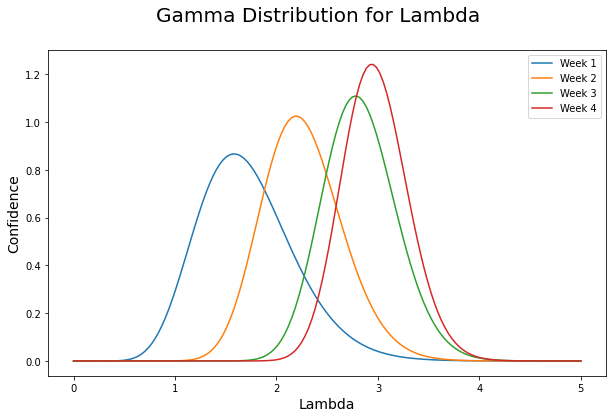

In [171]:
n = 7
## Initial beta calculation for the prior
lambda_mme = np.mean(deaths[:n])
# taking from lambda_mme
beta = lambda_mme

x = np.linspace(0, 5, 150) 
y=[]
fig = plt.figure(figsize=(10,6))
fig.suptitle('Gamma Distribution for Lambda', fontsize=20)
plt.xlabel('Lambda', fontsize=14)
plt.ylabel('Confidence', fontsize=14)
print("MAP values ")
for i in range(4):
  # computing posterior for each week.
  alpha = np.sum(deaths[:i*n + n]) + 1
  scale = 1.0/((i+1)*n + 1.0/beta)
  y.append(gamma.pdf(x, a=alpha, scale = scale ))
  # print('MAP for week ',i+1,np.max(y[i]))
  print("Week-"+str(i+1),"Lambda (X-Axis)",x[np.argmax(y[i])],"\tConfidence(Y-axis)",np.max(y[i]))
  plt.plot(x, y[i], label=('Week '+str(i+1)))
plt.legend()

**Observations**

* These graphs depicts that as the weeks progresses, the number of deaths are increasing and thus the MAP for the Lambda parameter is increasing.
* Confidence in MAP value is increasing as the weeks are increasing.
* We can also observe that the rate of increase of MAP of Lambda is decreasing. Thus we can infer that increase in deaths per week is going towards saturation.

---
---
# **4. Sample inferences (3):** 

### **4.1 Use Chi-square independence test to check if COVID19 impacted your X dataset in some way.**

---
 *    ### **Chi-square independence Test 1**

     *Chosen X Dataset for this task:* **`SearchTrends.csv`**

     *Selected Time Period:* **`February to April (2019 and 2020)`**

    We are comparing search trends of [ cold, flu, pneumonia ] for year 2019 and year 2020. Particularly we chose the interval of February to April for each year to check the independence of aggregate searches in those time period (with and without pandemic) and decide whether they are independent or not.

  $H_o$:  `Search trends [ cold, flu, pneumonia ] independent of COVID time-period.`

  $H_1$:  `Search trends [ cold, flu, pneumonia ] not independent of COVID time-period.`


In [0]:
# We filter the dates from February to April from our X dataset and prepare the chi-square table as shown below

r1 = trend_df[trend_df.date >= '2020-02-01'].mean().tolist()
del r1[-1]
r2 = trend_df[(trend_df.date >= '2019-02-01') & (trend_df.date <= '2019-04-29')].mean().tolist()
del r2[-1]
chisq = pd.DataFrame(columns = ['Year','cold','flu','pneumonia'])
r1.insert(0,'2019')
r2.insert(0,'2020')
chisq.loc[len(chisq)] = r1
chisq.loc[len(chisq)] = r2
chisq['Total'] = chisq.sum(axis=1)
chisq.loc['Total']= chisq.sum()
chisq.loc[chisq.index =='Total', 'Year']=''

In [173]:
chisq

,Year,cold,flu,pneumonia,Total
0,2019,0.681204,0.133843,0.444408,1.259454
1,2020,0.326229,0.279948,0.161711,0.767889
Total,,1.007433,0.413791,0.606119,2.027343


In [0]:
# We calculate the expected values and append them to a list.

column = ['cold','flu','pneumonia']
obs_val = []
exp_val = []
for index, rows in chisq.iterrows(): 
    if(index !='Total'):
      exp = []
      for col in column:
        exp.append((chisq.iloc[-1][col]/chisq.iloc[-1][-1])*chisq.iloc[index][-1])
      obs = [rows.cold, rows.flu, rows.pneumonia]
      obs_val.append(obs)
      exp_val.append(exp) 

In [175]:
# Using the two lists (observed and expected values), calculate chi-square from the table

sum = 0
for i in range(len(obs_val)):
    for j in range(len(obs_val[1])):
        sum += ((obs_val[i][j]- exp_val[i][j])**2)/exp_val[i][j]

dof = (len(obs_val)-1)*(len(obs_val[1])-1)
print("Degrees of Freedom: ",dof)
print("Chi-square (X2) value: ",sum)

Degrees of Freedom:  2
Chi-square (X2) value:  0.20115381070148514


**Result-1:**

CDF at Chi-square ($Χ^2$) value **0.20115** = `0.09568`

P-Value = 1 - 0.09568 = `0.90432`

Since, p-value > 0.05, we accept $H_o$, which states that search trends [ cold, flu, pneumonia ] are independent of COVID time-period.


---
Now we plan to check independence of each individual month from the previous year which match to COVID-19 time range.
 *    ### **Chi-square independence Test 2**    

    *Chosen X Dataset for this task:* **`SearchTrends.csv`**

    *Selected Time Period:* **`February (2019 and 2020)`**

    We are comparing search trends of [ cold, flu, pneumonia ] for year 2019 and year 2020. Particularly, we chose the month of **February** for each year to check the independence of aggregate searches in this time period (with and without pandemic) and decide whether they are independent or not.

  $H_o$:  `Search trends [ cold, flu, pneumonia ] independent of COVID time-period.`

  $H_1$:  `Search trends [ cold, flu, pneumonia ] not independent of COVID time-period.`



In [0]:
# We filter the dates of February from our X dataset and prepare the chi-square table as shown below

r1 = trend_df[(trend_df.date >= '2020-02-01') & (trend_df.date <= '2020-02-29')].mean().tolist()
# r1 = [r*100 for r in r1]
del r1[-1]
r2 = trend_df[(trend_df.date >= '2019-02-01') & (trend_df.date <= '2019-02-29')].mean().tolist()
# r2 = [r*100 for r in r2]
del r2[-1]
chisq = pd.DataFrame(columns = ['Year','cold','flu','pneumonia'])
r1.insert(0,'Feb 2019')
r2.insert(0,'Feb 2020')
chisq.loc[len(chisq)] = r1
chisq.loc[len(chisq)] = r2
chisq['Total'] = chisq.sum(axis=1)
chisq.loc['Total']= chisq.sum()
chisq.loc[chisq.index =='Total', 'Year']=''

In [177]:
chisq

,Year,cold,flu,pneumonia,Total
0,Feb 2019,1.000226,0.228289,0.805069,2.033583
1,Feb 2020,0.083795,0.102417,0.131764,0.317976
Total,,1.084021,0.330706,0.936833,2.351559


In [0]:
# We calculate the expected values and append them to a list.

column = ['cold','flu','pneumonia']
obs_val = []
exp_val = []
for index, rows in chisq.iterrows(): 
    if(index !='Total'):
      exp = []
      for col in column:
        exp.append((chisq.iloc[-1][col]/chisq.iloc[-1][-1])*chisq.iloc[index][-1])
      obs = [rows.cold, rows.flu, rows.pneumonia]
      obs_val.append(obs)
      exp_val.append(exp) 

In [179]:
# Using the two lists (observed and expected values), calculate chi-square from the table
sum = 0
for i in range(len(obs_val)):
    for j in range(len(obs_val[1])):
        sum += ((obs_val[i][j]- exp_val[i][j])**2)/exp_val[i][j]

dof = (len(obs_val)-1)*(len(obs_val[1])-1)
print("Degrees of Freedom: ",dof)
print("Chi-square (X2) value: ",sum)

Degrees of Freedom:  2
Chi-square (X2) value:  0.11742520094249063


**Result-2:**
CDF at Chi-square ($Χ^2$) value **0.11743** = `0.05701`

P-Value = 1 - 0.05701 = `0.94299`

Since, p-value > 0.05, we accept $H_o$, which states that search trends [ cold, flu, pneumonia ] are independent of COVID time-period.


---
*   ### **Chi-square independence Test 3**

    *Chosen X Dataset for this task:* ***`SearchTrends.csv`***

    *Selected Time Period*: ***`March (2019 and 2020)`***

    We are comparing search trends of [ cold, flu, pneumonia ] for year 2019 and year 2020. Particularly, we chose the month of **March** for both the years  to check the independence of aggregate searches in this time period (with and without pandemic) and decide whether they are independent or not.

  $H_o$:  `Search trends [ cold, flu, pneumonia ] independent of COVID time-period.`

  $H_1$:  `Search trends [ cold, flu, pneumonia ] not independent of COVID time-period.`



In [0]:
# We filter the dates of March from our X dataset and prepare the chi-square table as shown below

r1 = trend_df[(trend_df.date >= '2020-03-01') & (trend_df.date <= '2020-03-31')].mean().tolist()
del r1[-1]
r2 = trend_df[(trend_df.date >= '2019-03-01') & (trend_df.date <= '2019-03-31')].mean().tolist()
del r2[-1]
chisq = pd.DataFrame(columns = ['Year','cold','flu','pneumonia'])
r1.insert(0,'March 2019')
r2.insert(0,'March 2020')
chisq.loc[len(chisq)] = r1
chisq.loc[len(chisq)] = r2
chisq['Total'] = chisq.sum(axis=1)
chisq.loc['Total']= chisq.sum()
chisq.loc[chisq.index =='Total', 'Year']=''

In [181]:
chisq

,Year,cold,flu,pneumonia,Total
0,March 2019,0.673667,0.097356,0.304804,1.075827
1,March 2020,0.721709,0.229631,0.153791,1.105131
Total,,1.395376,0.326986,0.458595,2.180958


In [0]:
# We calculate the expected values and append them to a list.

column = ['cold','flu','pneumonia']
obs_val = []
exp_val = []
for index, rows in chisq.iterrows(): 
    if(index !='Total'):
      exp = []
      for col in column:
        exp.append((chisq.iloc[-1][col]/chisq.iloc[-1][-1])*chisq.iloc[index][-1])
      obs = [rows.cold, rows.flu, rows.pneumonia]
      obs_val.append(obs)
      exp_val.append(exp) 

In [183]:
# Using the two lists (observed and expected values), calculate chi-square from the table

sum = 0
for i in range(len(obs_val)):
    for j in range(len(obs_val[1])):
        sum += ((obs_val[i][j]- exp_val[i][j])**2)/exp_val[i][j]

dof = (len(obs_val)-1)*(len(obs_val[1])-1)
print("Degrees of Freedom: ",dof)
print("Chi-square (X2) value: ",sum)

Degrees of Freedom:  2
Chi-square (X2) value:  0.10451565276494187


**Result-3:**
CDF at Chi-square ($Χ^2$) value **0.10452** = `0.05091`

P-Value = 1 - 0.05091 = `0.94909`

Since, p-value > 0.05, we accept $H_o$, which states that search trends [ cold, flu, pneumonia ] are independent of COVID time-period.


---
*   ### **Chi-square independence Test 4**

    *Chosen X Dataset for this task:* ***`SearchTrends.csv`***
    
    *Selected Time Period*: ***`April (2019 and 2020)`***

    We are comparing search trends of [ cold, flu, pneumonia ] for year 2019 and year 2020. Particularly we chose the month of **April** for both the years to check the independence of aggregate searches in this time period (with and without pandemic) and decide whether they are independent or not.

  $H_o$:  `Search trends [ cold, flu, pneumonia ] independent of COVID time-period.`

  $H_1$:  `Search trends [ cold, flu, pneumonia ] not independent of COVID time-period.`



In [0]:
# We filter the dates of April from our X dataset and prepare the chi-square table as shown below

r1 = trend_df[(trend_df.date >= '2020-04-01') & (trend_df.date <= '2020-04-29')].mean().tolist()
del r1[-1]
r2 = trend_df[(trend_df.date >= '2019-04-01') & (trend_df.date <= '2019-04-29')].mean().tolist()
del r2[-1]
chisq = pd.DataFrame(columns = ['Year','cold','flu','pneumonia'])
r1.insert(0,'April 2019')
r2.insert(0,'April 2020')
chisq.loc[len(chisq)] = r1
chisq.loc[len(chisq)] = r2
chisq['Total'] = chisq.sum(axis=1)
chisq.loc['Total']= chisq.sum()
chisq.loc[chisq.index =='Total', 'Year']=''

In [185]:
chisq

,Year,cold,flu,pneumonia,Total
0,April 2019,0.206574,0.049219,0.121699,0.377492
1,April 2020,0.137549,0.505146,0.199093,0.841788
Total,,0.344123,0.554365,0.320792,1.219280


In [0]:
# We calculate the expected values and append them to a list.

column = ['cold','flu','pneumonia']
obs_val = []
exp_val = []
for index, rows in chisq.iterrows(): 
    if(index !='Total'):
      exp = []
      for col in column:
        exp.append((chisq.iloc[-1][col]/chisq.iloc[-1][-1])*chisq.iloc[index][-1])
      obs = [rows.cold, rows.flu, rows.pneumonia]
      obs_val.append(obs)
      exp_val.append(exp) 

In [187]:
# Using the two lists (observed and expected values), calculate chi-square from the table

sum = 0
for i in range(len(obs_val)):
    for j in range(len(obs_val[1])):
        sum += ((obs_val[i][j]- exp_val[i][j])**2)/exp_val[i][j]

dof = (len(obs_val)-1)*(len(obs_val[1])-1)
print("Degrees of Freedom: ",dof)
print("Chi-square (X2) value: ",sum)

Degrees of Freedom:  2
Chi-square (X2) value:  0.2698078078948756


**Result-4:**
CDF at Chi-square ($Χ^2$) value **0.26981** = `0.126196`

P-Value = 1 - 0.126196 = `0.873804`

Since, p-value > 0.05, we accept $H_o$, which states that search trends [ cold, flu, pneumonia ] are independent of COVID time-period.


---
---
### **4.2 Use your X dataset to check if COVID19 had an impact on the X data.**

* For this inference, we consider Seoul's floating population data. Floating population can be described as people who are not residents of a particular city/area but regulary visit there for work-related or tourism purposes. 

* We conduct an Unpaired T-test where we consider the first population to be the means of daily floating population in month of January and we consider the entire month data as a sample for it.

* We consider the second population to be the means of daily floating population in month of February and we consider the entire month data as a sample for it.

* Due to COVID-19 we expect that the average floating population should decrease during February due to stay at home orders.

* We filter the age of the population considered to be at most 20. (Considering for working population)

In [0]:
max_age_considered = 20
floating_original = floating_df[(floating_df.birth_year <= max_age_considered)] #filter the data for age of floating population

### **T-Test Details**

1. We do a one sided unpaired T-test where the hypothesis are:

  $H_o$:  `Mean(January) > Mean(Febrauary)`

  $H_1$:  `Mean(January) <= Mean(Febrauary)`

2. We do this for 2 districts of **Jungnang-gu** and **Jongno-gu**, where the former is a residential district and the latter is an industrial district.

3. $$ T =  \frac{U_{jan} - U_{feb } - 0}{\sqrt{\frac{S_{jan}^2}{n} + \frac{S_{feb}^2}{m}}} < - t(n + m -2, \alpha = 0.05) $$ 

In [0]:
#Jungnang-gu
dt_jan_jung = floating_original[(floating_original.date >= '2020-01-01') & (floating_original.date <= '2020-01-30') & (floating_original.city == 'Jungnang-gu')]
dt_feb_jung = floating_original[(floating_original.date >= '2020-02-01') & (floating_original.date <= '2020-03-01') & (floating_original.city == 'Jungnang-gu')]
#Jongno-gu
dt_jan_jong = floating_original[(floating_original.date >= '2020-01-01') & (floating_original.date <= '2020-01-30') & (floating_original.city == 'Jongno-gu')]
dt_feb_jong = floating_original[(floating_original.date >= '2020-02-01') & (floating_original.date <= '2020-03-01') & (floating_original.city == 'Jongno-gu')]

In [0]:
def floating_pop_t_test(jan_floating, feb_floating, district):
  jan_mean = jan_floating.mean()
  feb_mean = feb_floating.mean()
  sample_var_jan = 0
  sample_var_feb = 0
  for i in range(len(jan_floating)):
    sample_var_jan += ((jan_floating[i] - jan_mean)*(jan_floating[i] - jan_mean))/(len(jan_floating)*1.0)

  for i in range(len(feb_floating)):
    sample_var_feb += ((feb_floating[i] - feb_mean)*(feb_floating[i] - feb_mean))/(len(feb_floating)*1.0)
  
  pooled_standard_dev = sqrt(sample_var_jan + sample_var_feb)
  
  #Calculating T-statistic here
  t_statistic = (jan_mean - feb_mean - 0)/pooled_standard_dev

  degrees_of_freedom = len(jan_floating) + len(feb_floating) - 2

  #pre-calculated T-statistic for degrees_of_freedom(57)
  if t_statistic < -1.672:
    print("T unpaired test rejects the null hypothesis for district %s, statistic: %0.3f" % (district, t_statistic))
  else:
    print("T unpaired test accepts the null hypothesis for district %s, statistic: %0.3f" % (district, t_statistic))

**Jungnang-Gu Tests**

In [191]:
# Unpaired T-test
jung_floatpop_mean_jan = dt_jan_jung.groupby(['date'])['fp_num'].mean().values
jung_floatpop_mean_feb = dt_feb_jung.groupby(['date'])['fp_num'].mean().values
floating_pop_t_test(jung_floatpop_mean_jan, jung_floatpop_mean_feb, "Jungnang-Gu")

T unpaired test accepts the null hypothesis for district Jungnang-Gu, statistic: -0.322


**Jongno-Gu Tests**

In [192]:
# Unpaired T-test
jong_floatpop_mean_jan = dt_jan_jong.groupby(['date'])['fp_num'].mean().values
jong_floatpop_mean_feb = dt_feb_jong.groupby(['date'])['fp_num'].mean().values
floating_pop_t_test(jong_floatpop_mean_jan, jong_floatpop_mean_feb, "Jongno-gu")

T unpaired test accepts the null hypothesis for district Jongno-gu, statistic: -0.064


### **Inferences**

* In this case for Jungnang district, the statistic is closer to the threshold, which indicates that that the there is not much difference pre COVID and post COVID floating populations.

* In the case for Jongno district the T-test accepts with sufficient delta indicating that there was a difference pre and post COVID floating population. Thus we can say that COVID reduced the floating population in industrial districts.

### **Applicability of Tests**

* Since we use sufficiently large samples(30 for Jan, 29 for February) for both distributions and use sample mean as estimator, we can assume that CLT applies and the estimators are Normally distributed.

* Since the population samples are independent are approximately normally distributed; we satisfy the assumptions of the unpaired T-test and say that the test is applicable in the current scenario.

### **4.3 Linear Regression**

*   We have tried to find impact of **age on the duration of illness.**
*   We are considering patients who have been released from hospital or who are deceased.
*   **Train-Test Ratio -** 80:20
*   Later we have also implemented multiple linear including sex as an independent variable.

In [193]:
lr_data = patientinfo_df[['birth_year','sex','confirmed_date','released_date','state']].copy()

lr_data['birth_year'] = pd.to_numeric(lr_data['birth_year'])
lr_data['confirmed_date'] = lr_data['confirmed_date'].astype('datetime64[ns]')
lr_data['released_date'] = lr_data['released_date'].astype('datetime64[ns]')
lr_data['age']=2019-lr_data['birth_year']
lr_data=lr_data[lr_data.state !='isolated']
lr_data['recovery_days']=lr_data.released_date - lr_data.confirmed_date
lr_data['recovery_days'] = lr_data['recovery_days']/ np.timedelta64(1, 'D')
lr_data.sex[lr_data.sex=='male'] = 2
lr_data.sex[lr_data.sex=='female'] = 1
lr_data['sex'] = pd.to_numeric(lr_data['sex'])
lr_data = lr_data.dropna()

lr_data.head()

,birth_year,sex,confirmed_date,released_date,state,age,recovery_days
0,1964.0,2.0,2020-01-23,2020-02-05,released,55.0,13.0
1,1987.0,2.0,2020-01-30,2020-03-02,released,32.0,32.0
2,1964.0,2.0,2020-01-30,2020-02-19,released,55.0,20.0
3,1991.0,2.0,2020-01-30,2020-02-15,released,28.0,16.0
4,1992.0,1.0,2020-01-31,2020-02-24,released,27.0,24.0


* ##  **Simple Linear Regression**

$$ X = \{Age\} $$
$$ Y = \{Recovery\_days\} $$
\
$$\hat{\beta}_0=\bar{Y}-\hat{\beta}_1\bar{X}$$
$$\hat{\beta}_1=\frac{\sum X_iY_i - n \bar{X} \bar{Y}} {\sum {X_i}^2 - n(\bar{X})^2}$$
\
$$\hat{Y}_i=\hat{\beta}_0+\hat{\beta}_1X_i $$


MAPE: 43.500809992781186
Mean Squared Error: 77.50197959321905


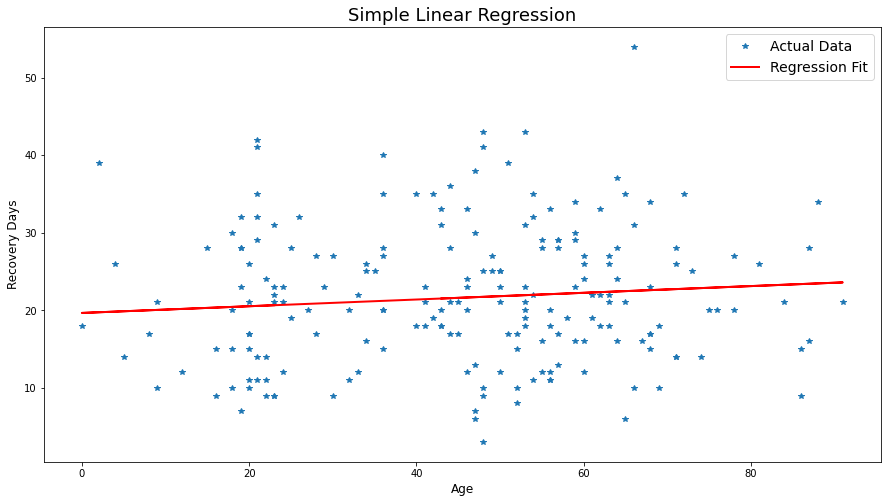

,Actual,Predicted
0,20.0,21.513769
1,21.0,21.557063
2,21.0,20.518024
3,15.0,20.431438
4,17.0,22.596101
...,...,...
197,32.0,20.561317
198,14.0,20.561317
199,13.0,21.686942
200,17.0,21.600356


In [194]:
#Splitting the data into 80% train and 20% test 
train,test = np.split(lr_data, [int(.8*len(lr_data))])

n = len(train)
XY = []
X_sq = []
X = train.age.values.tolist()
Y = train.recovery_days.values.tolist()

#Below part calculates B0 and B1 values as per formula given above
for i in range(n):
    XY.append (X[i]*Y[i])
    X_sq.append (X[i]**2)

X_bar = np.sum(X)/n
Y_bar = np.sum(Y)/n

num = np.sum(XY) - (n*X_bar*Y_bar)
den = np.sum(X_sq) - (n*(X_bar**2))
B1 = num/den
B0 = Y_bar - (B1*X_bar)

Y_cap = []
Y_act = []
X_act =[]

m=len(test)
x = test.age.values.tolist()    #Test data for prediction
y = test.recovery_days.values.tolist()  #Actual values for test data
for j in range(m):
    y_pred = B0+(B1*x[j])   #Predicted value is calculated usin B0 and B1
    Y_cap.append(y_pred)
    Y_act.append(y[j])
    X_act.append(x[j])

mse, mape = errors(Y_act, Y_cap)    #calculate errors like MAPE and MSE
print('MAPE:', mape)  
print('Mean Squared Error:', mse)  

#Below part plots the actual points and the predicted LR fit
plt.figure(figsize=(15, 8))
plt.title("Simple Linear Regression", size=18)
plt.plot(X_act,Y_act,'*', label='Actual Data')
plt.plot(X_act,Y_cap, color='red', linewidth=2, label="Regression Fit")
plt.xlabel("Age", size=12)
plt.ylabel("Recovery Days", size=12)
plt.legend(loc='best',prop={'size': 14})
plt.show()

result = pd.DataFrame({'Actual': Y_act, 'Predicted': Y_cap})
result

* ## **Multiple Linear Regression**

**Formulas Used:**
$$X = \{Age, Sex\}$$
$$Y = \{Recovery\_Days\}$$
\
$$ \hat{\beta} = (X^T.X)^{-1}X^T Y$$
$$[\hat{Y}] = [X] .[\hat{\beta}] $$

In [195]:
#Splitting the data into 80% train and 20% test
train,test = np.split(lr_data, [int(.8*len(lr_data))])

#Making 2d matrix for X_train and Y_train data
x_data = train[['age','sex']].reset_index(drop=True).values
temp = np.asarray([1]*len(train)).reshape(-1,1)
X_train = np.concatenate((temp, x_data),axis=1)
Y_train = np.asarray(train['recovery_days']).reshape(-1,1)

#Making 2d matrix for X_test and Y_test data
x_data = test[['age','sex']].reset_index(drop=True).values
temp = np.asarray([1]*len(test)).reshape(-1,1)
X_test = np.concatenate((temp, x_data),axis=1)
Y_test = np.asarray(test['recovery_days']).reshape(-1,1)

#Calculating the Beta matrix using formula given above
Beta = beta_cal(X_train,Y_train)

#Calculating Y predicted matrix using formula given
Y_hat = np.dot(X_test,Beta)

result = pd.DataFrame({'Actual': Y_test.flatten(), 'Predicted': Y_hat.flatten()})

#Caclulating errors like MAPE and MSE
mse, mape = errors(Y_test, Y_hat)
print('MAPE:', mape[0])  
print('Mean Squared Error:', mse[0]) 

coeff_df = pd.DataFrame(Beta[1:], ['age','sex'], columns=['Coefficient'])  
coeff_df

MAPE: 43.466360116770176
Mean Squared Error: 79.10708426976191


,Coefficient
age,0.037869
sex,-1.255416


In [196]:
result

,Actual,Predicted
0,20.0,21.974378
1,21.0,22.012247
2,21.0,19.847981
3,15.0,21.027659
4,17.0,21.665682
...,...,...
197,32.0,19.885850
198,14.0,21.141265
199,13.0,22.125854
200,17.0,20.794700


### **Analysis**


*   In Simple Linear Regression, we can observe that there is little relation between age and the no. of days taken to recover.
*   In multiple Linear Regression adding new feature of 'sex', did not provide a better fit with recovery days. 

